## Zillow Time Series Data

#### Target audience: Chicago area short term investor making a profit within 6-months. We are building a model which predicts the 4-6 month range. 

## Import libraries

In [4]:
# ! pip install cufflinks --upgrade 

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")
from plotly.graph_objs import FigureWidget
import plotly.plotly as py
import cufflinks as cf

### Load in data from csv file

In [5]:
zillow_df = pd.read_csv('../data/raw/zillow_data.csv')

In [6]:
zillow_df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06   ...     2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0   ...     1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0   ...      308000   310000   312500   
2         3  210400.0  212200.0  212200.0   ...      321000   320600   320200   
3         4  498100.0  500900.0  503100.0   ...     1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0   ...      119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [7]:
len(zillow_df['City'].unique())

7554

### Filter for the city of Chicago. 

In [8]:
chicago_df = zillow_df[zillow_df['City']=='Chicago']

In [9]:
zillow_dates = chicago_df[chicago_df.columns[7:]]
zillow_dates.head()

1996-04   1996-05   1996-06   1996-07   1996-08   1996-09   1996-10  \
0   334200.0  335400.0  336500.0  337600.0  338500.0  339500.0  340400.0   
3   498100.0  500900.0  503100.0  504600.0  505500.0  505700.0  505300.0   
7   216500.0  216700.0  216900.0  217000.0  217100.0  217200.0  217500.0   
16  122700.0  122800.0  122800.0  122700.0  122400.0  122000.0  121500.0   
19  142600.0  143100.0  143400.0  143300.0  142900.0  142200.0  141300.0   

     1996-11   1996-12   1997-01   ...     2017-07  2017-08  2017-09  2017-10  \
0   341300.0  342600.0  344400.0   ...     1005500  1007500  1007800  1009600   
3   504200.0  503600.0  503400.0   ...     1289800  1287700  1287400  1291500   
7   217900.0  218600.0  219700.0   ...      798000   787100   776100   774900   
16  120900.0  120500.0  120300.0   ...      459600   461400   464300   466500   
19  140100.0  139000.0  138000.0   ...      462700   461200   459900   459200   

    2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0   1013300  1018700  1024400  1030700  1033800  1030600  
3   1296600  1299000  1302700  1306400  1308500  1307000  
7    777900   777900   778500   780500   782800   782800  
16   467900   470600   474500   475100   472600   470200  
19   458700   457900   457400   459000   462500   464300  

[5 rows x 265 columns]

### Transpose the entire dataframe so that the date columns become rows. 

In [10]:
zillow_T = zillow_dates.T
zillow_T.reset_index(inplace=True)

In [11]:
chicago_index = zillow_df.index[zillow_df['City']=='Chicago']
chicago_index

Int64Index([   0,    3,    7,   16,   19,   40,   48,   50,   74,   79,  105,
             150,  157,  215,  231,  284,  318,  324,  332,  347,  497,  638,
             658,  739,  792, 1012, 1360, 1454, 1496, 1727, 1990, 2360, 2420,
            2585, 2830, 3149, 3156, 3960, 4040, 4362, 7863],
           dtype='int64')

In [12]:
chicago_index = chicago_index.astype(str)

### Rename the index column as date

In [13]:
zillow_T.rename(columns={'index':'date'}, inplace=True)
zillow_T.head()

date         0         3         7        16        19        40  \
0  1996-04  334200.0  498100.0  216500.0  122700.0  142600.0  297900.0   
1  1996-05  335400.0  500900.0  216700.0  122800.0  143100.0  300400.0   
2  1996-06  336500.0  503100.0  216900.0  122800.0  143400.0  302600.0   
3  1996-07  337600.0  504600.0  217000.0  122700.0  143300.0  304700.0   
4  1996-08  338500.0  505500.0  217100.0  122400.0  142900.0  306600.0   

        48        50       74   ...         2360      2420      2585  \
0  93400.0  148900.0  76400.0   ...     100900.0  215600.0  165400.0   
1  94100.0  149300.0  77000.0   ...     101400.0  215100.0  165300.0   
2  94600.0  149600.0  77400.0   ...     101900.0  214500.0  165000.0   
3  94800.0  149700.0  77700.0   ...     102300.0  213900.0  164600.0   
4  94700.0  149700.0  77700.0   ...     102700.0  213200.0  164100.0   

       2830      3149      3156      3960      4040      4362     7863  
0  103700.0  180900.0  166300.0  125700.0  197300.0  224100.0  77900.0  
1  104400.0  182200.0  166900.0  126300.0  198900.0  223300.0  78200.0  
2  104700.0  183100.0  167200.0  126600.0  200100.0  222400.0  78300.0  
3  104700.0  183500.0  167100.0  126500.0  200800.0  221500.0  78500.0  
4  104400.0  183400.0  166900.0  126100.0  201000.0  220500.0  78500.0  

[5 rows x 42 columns]

### Change data column to a datetime object

In [14]:
zillow_T['date'] = pd.to_datetime(zillow_T['date'])
# zillow_T.info()

### Grabbed zipcodes from corresponding index

In [15]:
chicago_zips = zillow_df.RegionName.iloc[chicago_index.astype(int)]
chicago_zips.head()

0     60657
3     60614
7     60640
16    60647
19    60618
Name: RegionName, dtype: int64

### Renaming column names from index to zipcodes

In [16]:
zillow_T.columns = ['date']+list(chicago_zips)
zillow_chicago = zillow_T
zillow_chicago.head()

date     60657     60614     60640     60647     60618     60613  \
0 1996-04-01  334200.0  498100.0  216500.0  122700.0  142600.0  297900.0   
1 1996-05-01  335400.0  500900.0  216700.0  122800.0  143100.0  300400.0   
2 1996-06-01  336500.0  503100.0  216900.0  122800.0  143400.0  302600.0   
3 1996-07-01  337600.0  504600.0  217000.0  122700.0  143300.0  304700.0   
4 1996-08-01  338500.0  505500.0  217100.0  122400.0  142900.0  306600.0   

     60629     60625    60619   ...        60612     60607     60659  \
0  93400.0  148900.0  76400.0   ...     100900.0  215600.0  165400.0   
1  94100.0  149300.0  77000.0   ...     101400.0  215100.0  165300.0   
2  94600.0  149600.0  77400.0   ...     101900.0  214500.0  165000.0   
3  94800.0  149700.0  77700.0   ...     102300.0  213900.0  164600.0   
4  94700.0  149700.0  77700.0   ...     102700.0  213200.0  164100.0   

      60652     60631     60656     60655     60646     60642    60633  
0  103700.0  180900.0  166300.0  125700.0  197300.0  224100.0  77900.0  
1  104400.0  182200.0  166900.0  126300.0  198900.0  223300.0  78200.0  
2  104700.0  183100.0  167200.0  126600.0  200100.0  222400.0  78300.0  
3  104700.0  183500.0  167100.0  126500.0  200800.0  221500.0  78500.0  
4  104400.0  183400.0  166900.0  126100.0  201000.0  220500.0  78500.0  

[5 rows x 42 columns]

### Making date column the index

In [17]:
zillow_chicago.set_index('date', inplace=True)

In [18]:
zillow_chicago.head()

60657     60614     60640     60647     60618     60613  \
date                                                                     
1996-04-01  334200.0  498100.0  216500.0  122700.0  142600.0  297900.0   
1996-05-01  335400.0  500900.0  216700.0  122800.0  143100.0  300400.0   
1996-06-01  336500.0  503100.0  216900.0  122800.0  143400.0  302600.0   
1996-07-01  337600.0  504600.0  217000.0  122700.0  143300.0  304700.0   
1996-08-01  338500.0  505500.0  217100.0  122400.0  142900.0  306600.0   

              60629     60625    60619     60610   ...        60612     60607  \
date                                               ...                          
1996-04-01  93400.0  148900.0  76400.0  435200.0   ...     100900.0  215600.0   
1996-05-01  94100.0  149300.0  77000.0  435200.0   ...     101400.0  215100.0   
1996-06-01  94600.0  149600.0  77400.0  435100.0   ...     101900.0  214500.0   
1996-07-01  94800.0  149700.0  77700.0  434600.0   ...     102300.0  213900.0   
1996-08-01  94700.0  149700.0  77700.0  433900.0   ...     102700.0  213200.0   

               60659     60652     60631     60656     60655     60646  \
date                                                                     
1996-04-01  165400.0  103700.0  180900.0  166300.0  125700.0  197300.0   
1996-05-01  165300.0  104400.0  182200.0  166900.0  126300.0  198900.0   
1996-06-01  165000.0  104700.0  183100.0  167200.0  126600.0  200100.0   
1996-07-01  164600.0  104700.0  183500.0  167100.0  126500.0  200800.0   
1996-08-01  164100.0  104400.0  183400.0  166900.0  126100.0  201000.0   

               60642    60633  
date                           
1996-04-01  224100.0  77900.0  
1996-05-01  223300.0  78200.0  
1996-06-01  222400.0  78300.0  
1996-07-01  221500.0  78500.0  
1996-08-01  220500.0  78500.0  

[5 rows x 41 columns]

### Saving the csv file 

In [19]:
zillow_chicago.to_csv('../data/processed/zillow_chicago_1996_to_2018')

After some analysis below, we went back to our original dataframe and decided to use a subset of the years from 2012 onwards. 

### Deflating 

In [20]:
deflation_factors_2017 = pd.DataFrame({'year': [2013, 2014, 2015, 2016, 2017, 2018, 2019], 
                          'factor': [0.950, 0.966, 0.967, 0.979, 1.000, 1.020, 1.042]})
deflation_factors_2017['year'] = pd.to_datetime(deflation_factors_2017['year'], format='%Y')
deflation_factors_2017.set_index('year', inplace=True)
deflation_mon_2017 = deflation_factors_2017.resample('M').ffill()
deflation_mon_2017 = deflation_mon_2017[:-9]
deflation_mon_2017.index = [pd.datetime(x.year, x.month, 1) for x in deflation_mon_2017.index.tolist()]
deflation_mon_2017.head()


factor
2013-01-01    0.95
2013-02-01    0.95
2013-03-01    0.95
2013-04-01    0.95
2013-05-01    0.95

### Choosing only certain years

In [21]:
zillow_chicago_d = pd.concat([zillow_chicago.loc['2013':,:], deflation_mon_2017], axis=1)
for column in zillow_chicago_d.columns[:-1]:
    zillow_chicago_d[column] = zillow_chicago_d[column].div(zillow_chicago_d['factor'])
zillow_chicago_d.head()

60657         60614          60640          60647  \
date                                                                    
2013-01-01  844526.315789  1.059263e+06  576210.526316  315473.684211   
2013-02-01  848526.315789  1.067053e+06  578842.105263  320631.578947   
2013-03-01  853578.947368  1.078737e+06  586000.000000  327157.894737   
2013-04-01  860421.052632  1.092947e+06  596631.578947  333894.736842   
2013-05-01  870315.789474  1.109368e+06  604210.526316  339052.631579   

                    60618          60613          60629          60625  \
date                                                                     
2013-01-01  341578.947368  816000.000000  118947.368421  349578.947368   
2013-02-01  344631.578947  820842.105263  119263.157895  351894.736842   
2013-03-01  348842.105263  824210.526316  119684.210526  356210.526316   
2013-04-01  354000.000000  828736.842105  120526.315789  362421.052632   
2013-05-01  359473.684211  837578.947368  122105.263158  367263.157895   

                    60619          60610   ...            60607  \
date                                       ...                    
2013-01-01  119368.421053  855789.473684   ...    440842.105263   
2013-02-01  117157.894737  864736.842105   ...    442631.578947   
2013-03-01  116421.052632  875894.736842   ...    445789.473684   
2013-04-01  114947.368421  885789.473684   ...    451578.947368   
2013-05-01  112631.578947  899578.947368   ...    455473.684211   

                    60659          60652          60631          60656  \
date                                                                     
2013-01-01  276631.578947  137789.473684  282210.526316  234631.578947   
2013-02-01  277789.473684  138315.789474  284421.052632  237263.157895   
2013-03-01  280842.105263  138947.368421  287578.947368  241263.157895   
2013-04-01  284315.789474  140000.000000  291894.736842  245684.210526   
2013-05-01  288526.315789  141789.473684  296842.105263  250947.368421   

                    60655          60646          60642         60633  factor  
date                                                                           
2013-01-01  192842.105263  334421.052632  446421.052632  89052.631579    0.95  
2013-02-01  193052.631579  336631.578947  448526.315789  88210.526316    0.95  
2013-03-01  194421.052632  339368.421053  451894.736842  87368.421053    0.95  
2013-04-01  196421.052632  342526.315789  457473.684211  86421.052632    0.95  
2013-05-01  198736.842105  346421.052632  464315.789474  84842.105263    0.95  

[5 rows x 42 columns]

In [32]:
zillow_chicago_d.index

DatetimeIndex(['2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
      

### Train-test-split and dropping 60611 zipcode, and dropping the factor column.

In [22]:
zillow_chicago_train = zillow_chicago_d.loc['2013':'2017-10',:]
zillow_chicago_test = zillow_chicago_d.loc['2018',:]


zillow_chicago_train.drop([60611, 'factor'], axis=1, inplace=True)
zillow_chicago_test.drop([60611, 'factor'], axis=1, inplace=True)

### Plotting all data prior to detrending

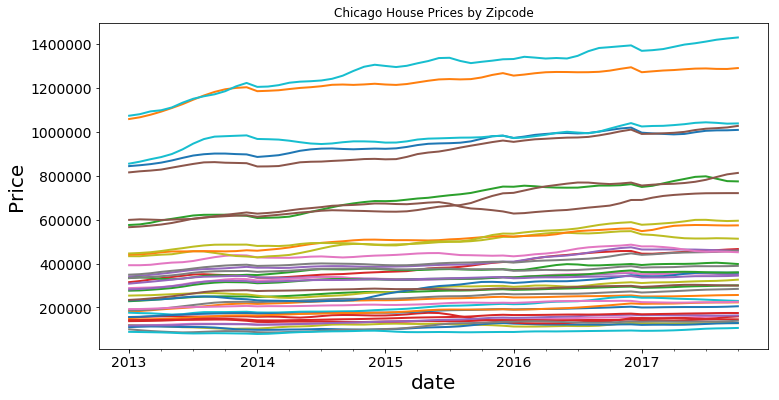

In [37]:
cat = zillow_chicago_train.plot(figsize=(12,6), linewidth=2, fontsize=14)
plt.xlabel('date', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.title('Chicago House Prices by Zipcode')
cat.legend().remove()

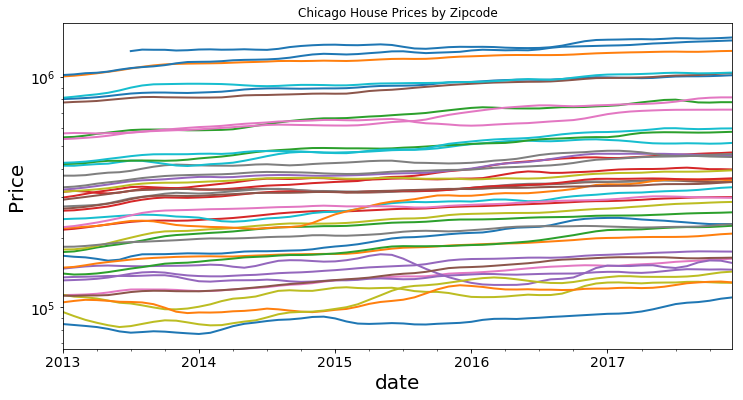

In [45]:
cat = zillow_chicago.plot(figsize=(12,6), linewidth=2, fontsize=14)
plt.xlabel('date', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.title('Chicago House Prices by Zipcode')
cat.legend().remove()
plt.yscale('log')

From the previous plot, we can see there is no seasonality in the data.

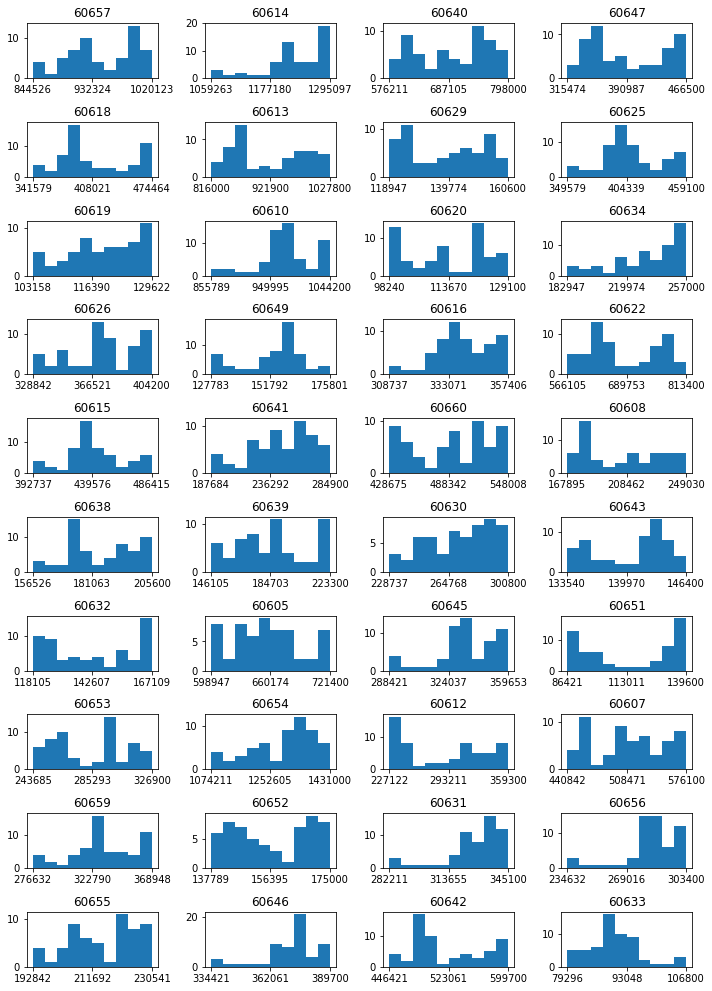

In [26]:
fig=plt.figure(figsize=(10,15))
# ax=plt.subplots(7,7)
for index, zipcode in enumerate(zillow_chicago_train.columns):
    ax = fig.add_subplot(11,4,index+1)
    h = ax.hist(zillow_chicago_train[zipcode])
    prices = h[1]
    ax.set_xticks(np.linspace(prices[0], prices[-1], 3))
    ax.set_title(zipcode)

# print(h[1])
plt.tight_layout();
# price and count of where it spent the most time at which price point

In order to run analysis on the zipcode, we need to detrend our data from any trends associated with climate, season, etc. 

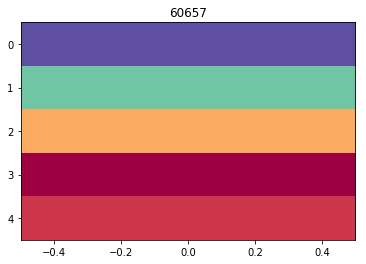

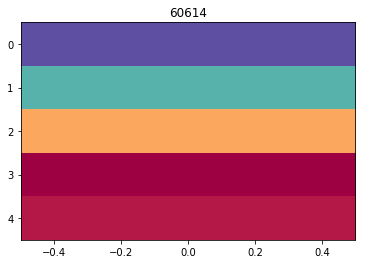

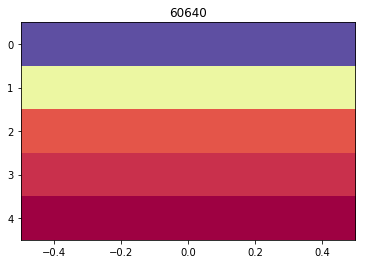

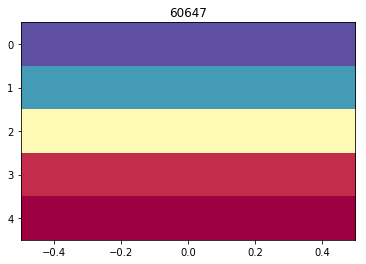

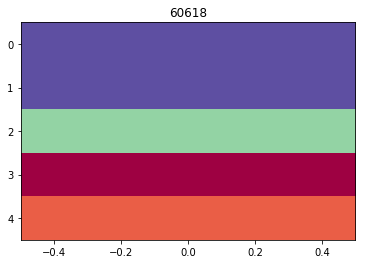

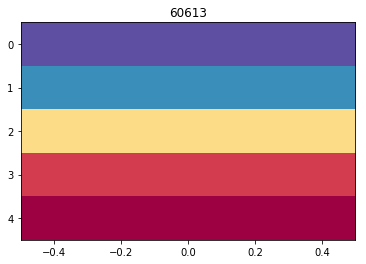

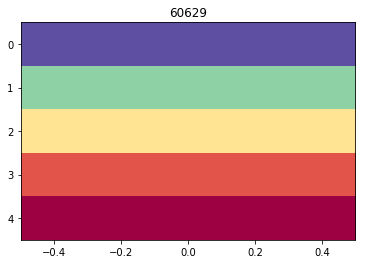

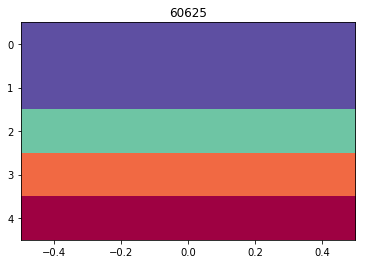

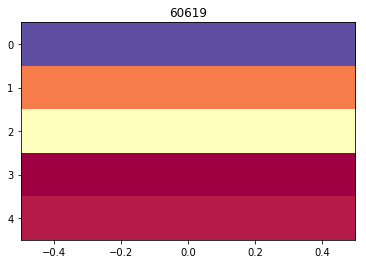

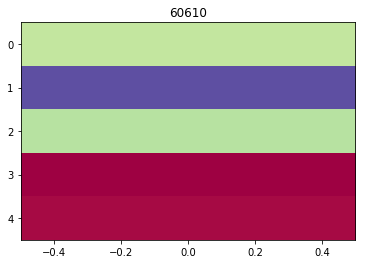

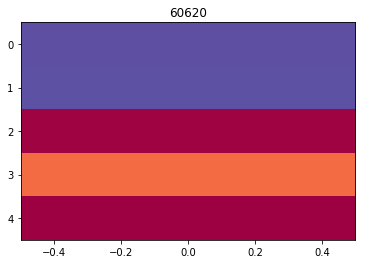

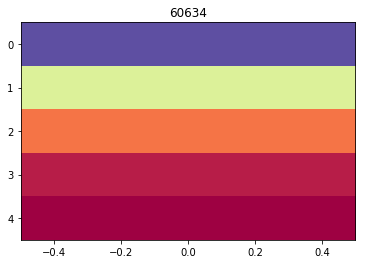

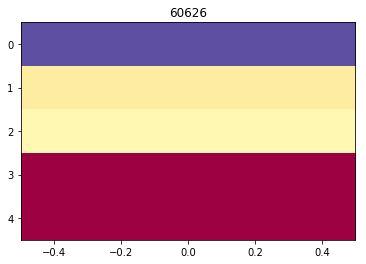

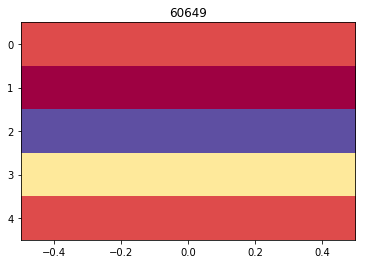

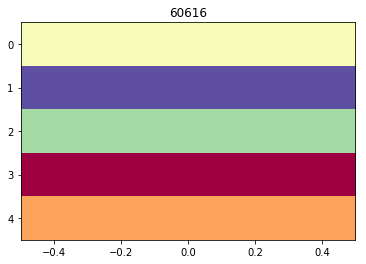

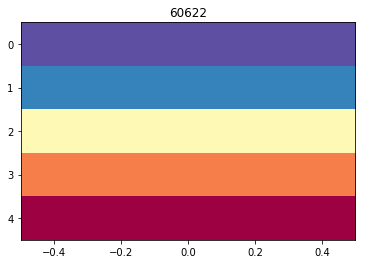

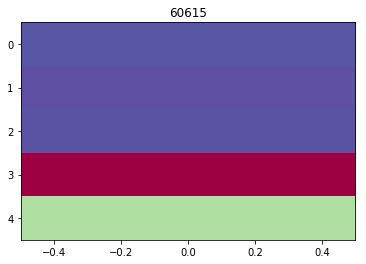

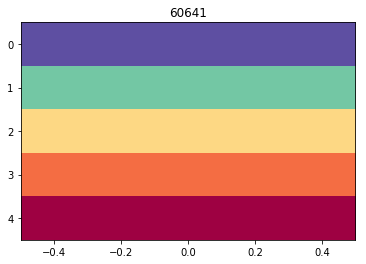

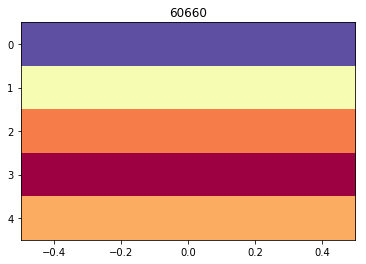

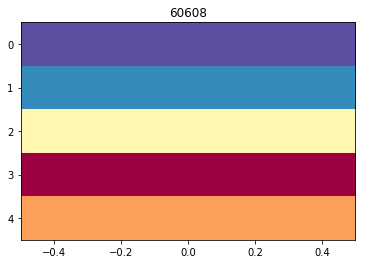

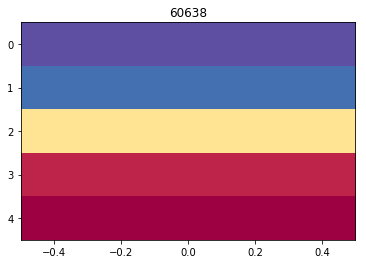

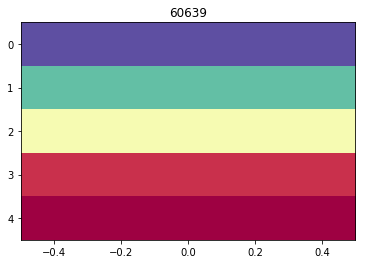

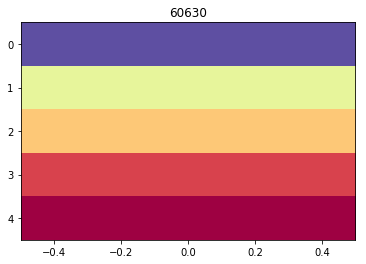

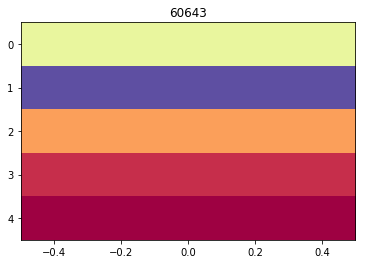

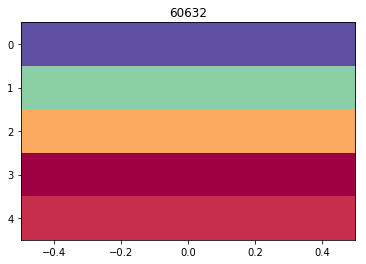

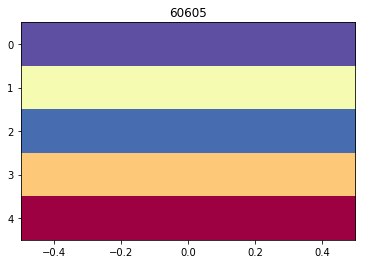

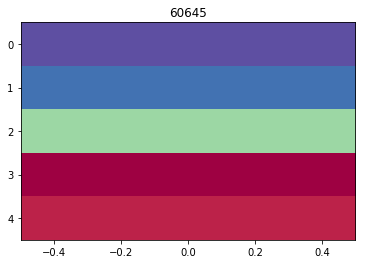

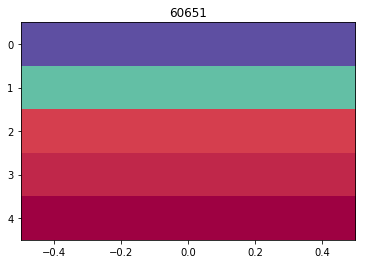

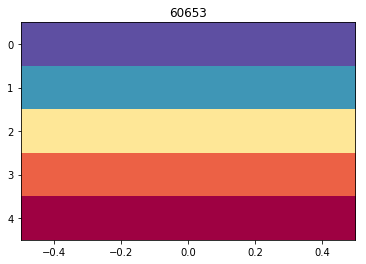

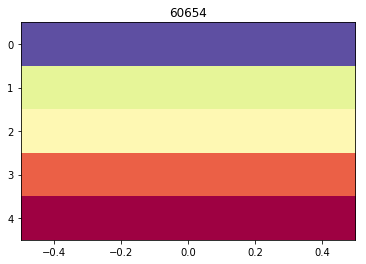

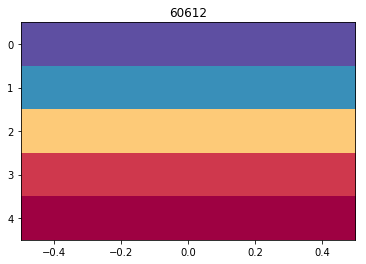

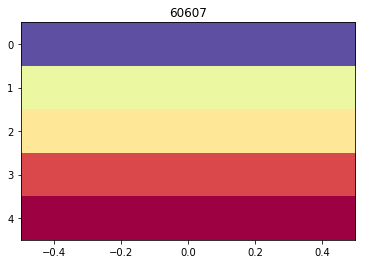

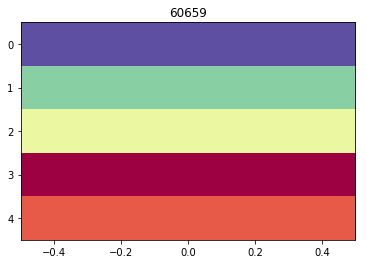

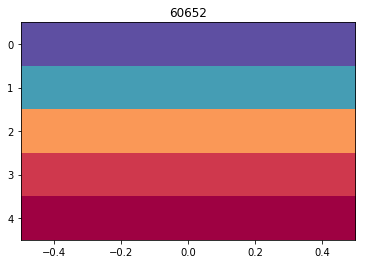

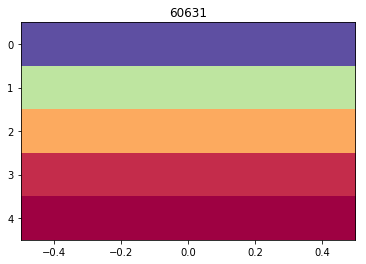

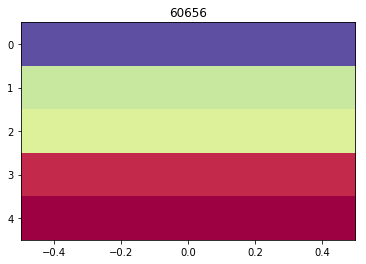

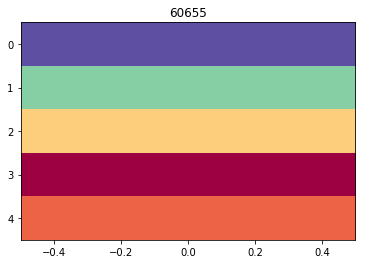

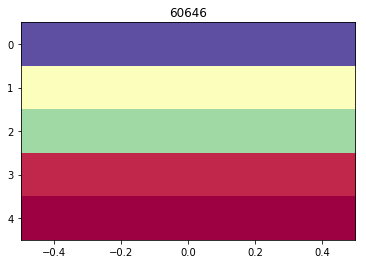

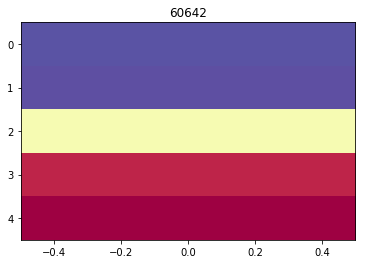

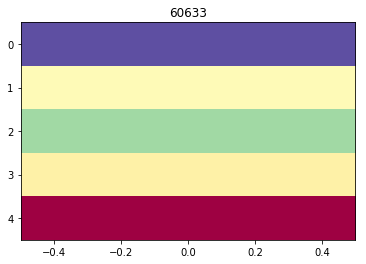

In [27]:
# Grouping data
for zipcode in list(zillow_chicago_train.columns):
    frequency = 'M' #string
    series = zillow_chicago_train[zipcode]
    frequency_groups = series.groupby(pd.Grouper(freq =frequency))
        # Plot grouped df
    df_annual = pd.DataFrame()  #creates blank df
    for yr, group in frequency_groups:
        df_annual[yr.year] = group.values.ravel()
        # Heatmaps
    year_matrix = df_annual.T #each row=1 year, each column=1 month
    plt.imshow(year_matrix, interpolation=None, aspect='auto', cmap=plt.cm.Spectral_r)
    plt.title('{}'.format(zipcode))
    plt.show()

# y-years
# x-time in months

From the rainbow plots above there is no visible seasonality in our data. 

### Rolling Mean

In [28]:
def stationarity_check(TS, column):
    '''Outputs a plot of the Rolling Mean and standard deviation and prints results of the Dickey-Fuller Test
      TS: Time Series, this is the dataframe from which you are pulling your information
      column: This is the column within the TS that you are interested in, e.g. the zipcode or stock ticker'''
    # Calculate rolling statistics
    rolmean = TS[column].rolling(window = 8, center = False).mean()
    rolstd = TS[column].rolling(window = 8, center = False).std()
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS[column].dropna()) # change the passengers column as required
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS[column], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for {}'.format(column))
    plt.show(block=False)
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


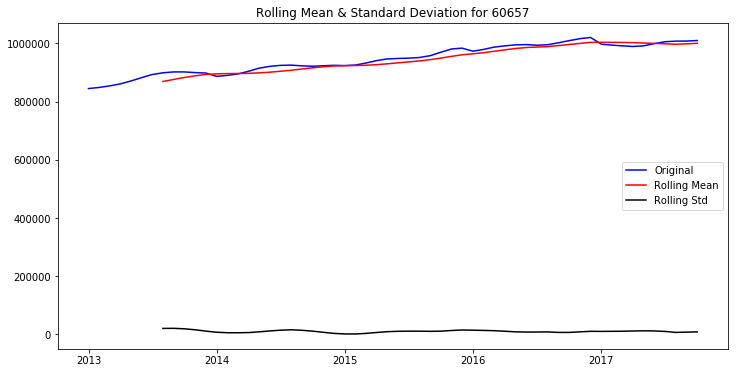

Results of Dickey-Fuller Test:
Test Statistic                 -1.656682
p-value                         0.453558
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


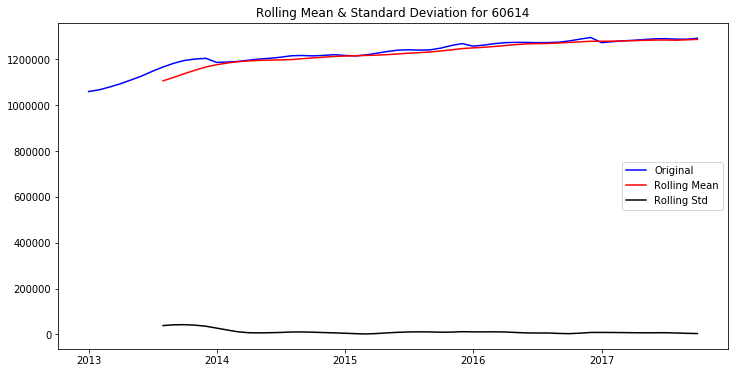

Results of Dickey-Fuller Test:
Test Statistic                 -2.449789
p-value                         0.128174
#Lags Used                      5.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


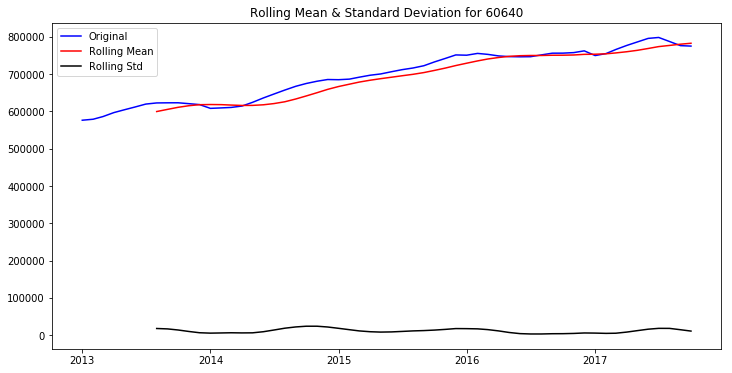

Results of Dickey-Fuller Test:
Test Statistic                 -1.083228
p-value                         0.721714
#Lags Used                      9.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


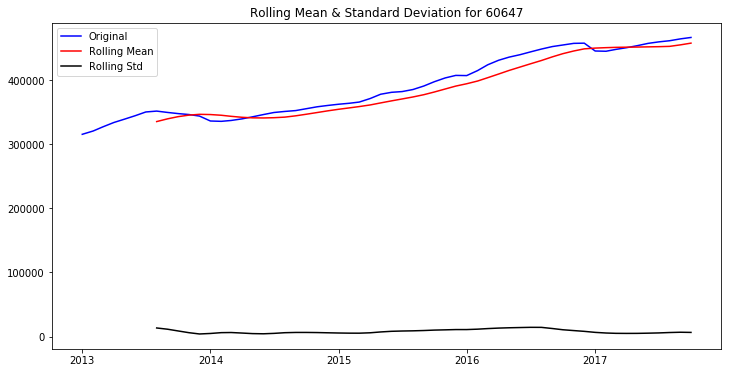

Results of Dickey-Fuller Test:
Test Statistic                 -0.319653
p-value                         0.922674
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


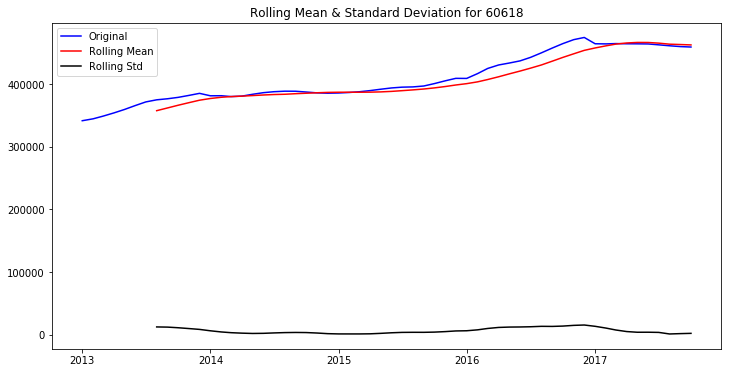

Results of Dickey-Fuller Test:
Test Statistic                 -1.188961
p-value                         0.678326
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


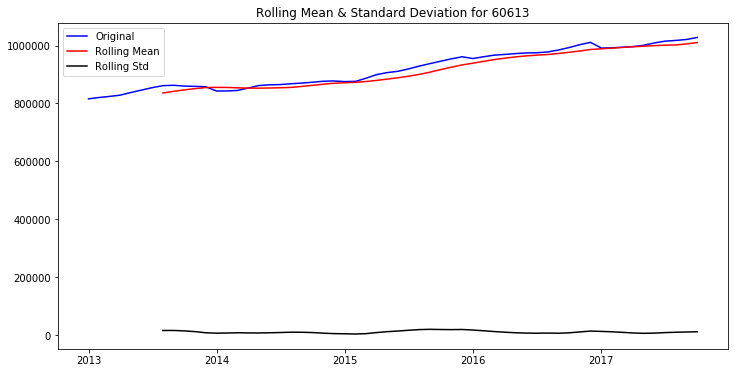

Results of Dickey-Fuller Test:
Test Statistic                 -0.167696
p-value                         0.942264
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


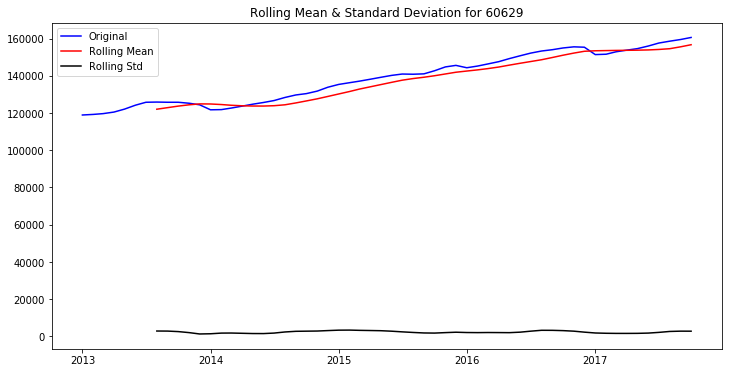

Results of Dickey-Fuller Test:
Test Statistic                 -0.274697
p-value                         0.929012
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


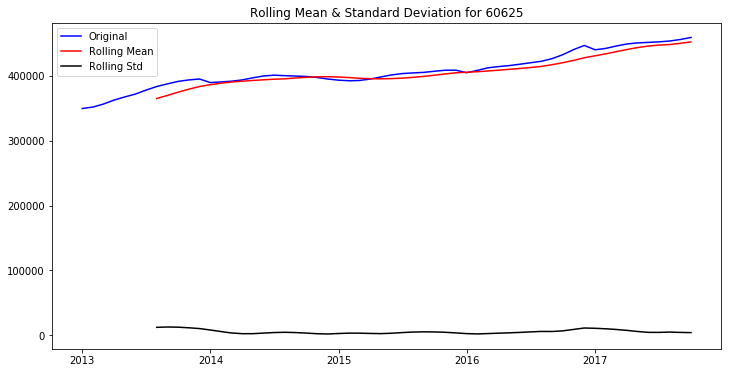

Results of Dickey-Fuller Test:
Test Statistic                 -0.903725
p-value                         0.786743
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


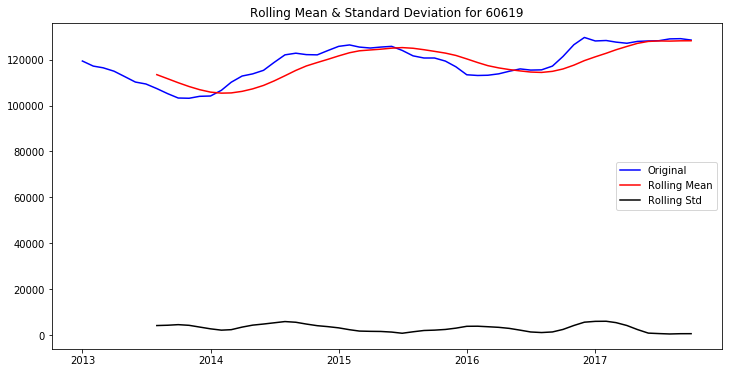

Results of Dickey-Fuller Test:
Test Statistic                 -2.629026
p-value                         0.087145
#Lags Used                      4.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


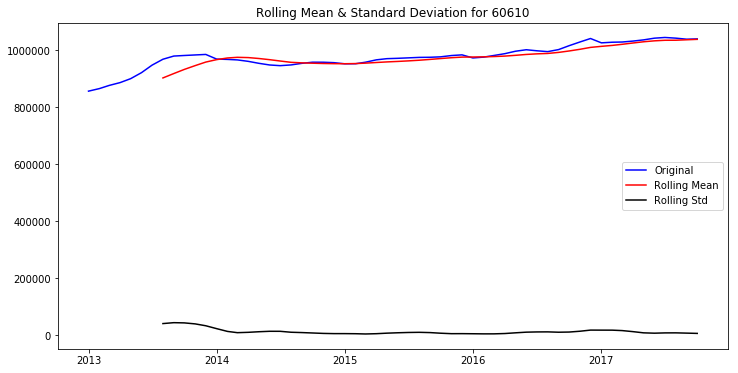

Results of Dickey-Fuller Test:
Test Statistic                  2.519066
p-value                         0.999056
#Lags Used                     11.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


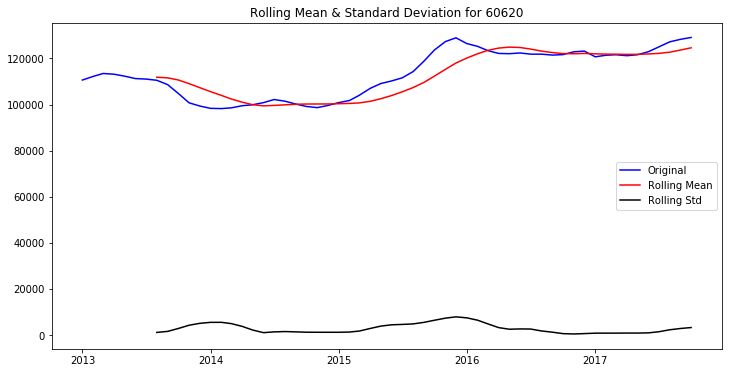

Results of Dickey-Fuller Test:
Test Statistic                 -1.243852
p-value                         0.654453
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


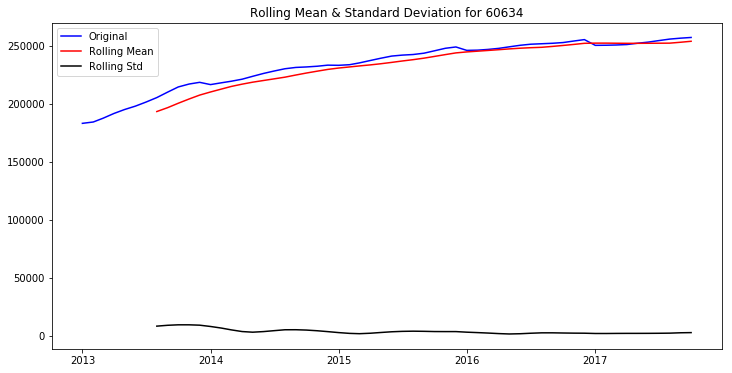

Results of Dickey-Fuller Test:
Test Statistic                 -5.413125
p-value                         0.000003
#Lags Used                      0.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


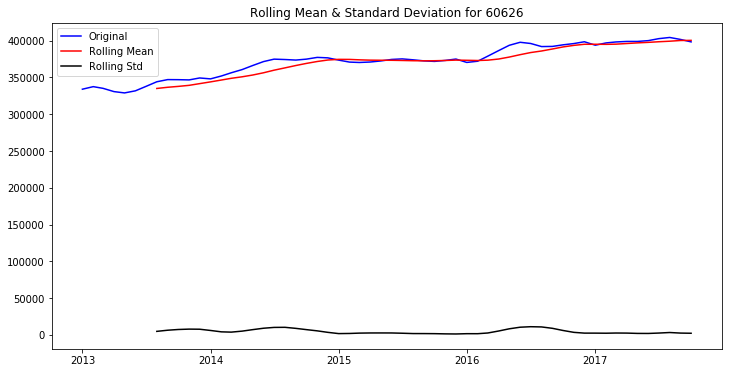

Results of Dickey-Fuller Test:
Test Statistic                 -1.347278
p-value                         0.607275
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


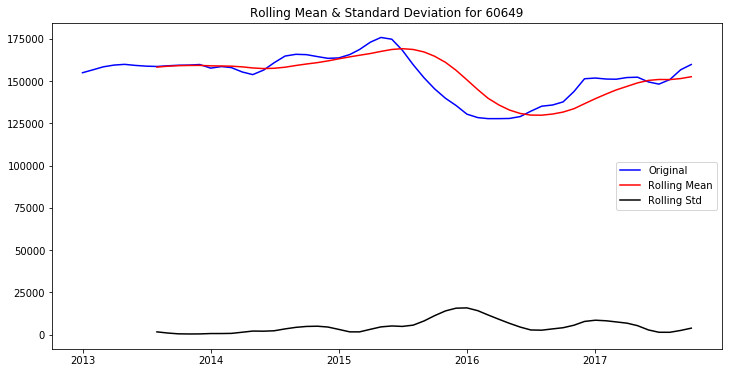

Results of Dickey-Fuller Test:
Test Statistic                 -2.221465
p-value                         0.198548
#Lags Used                      3.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


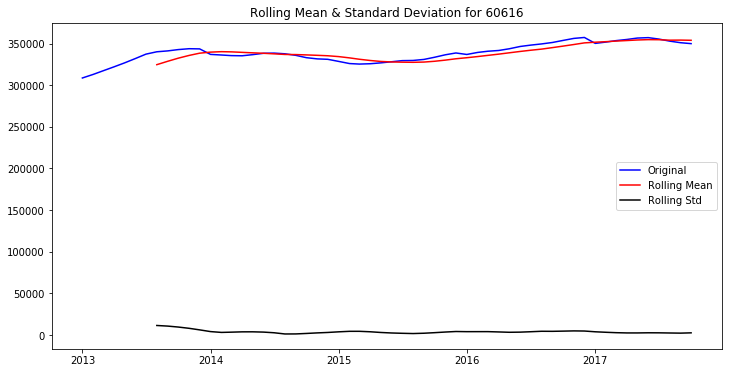

Results of Dickey-Fuller Test:
Test Statistic                 -2.217678
p-value                         0.199892
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


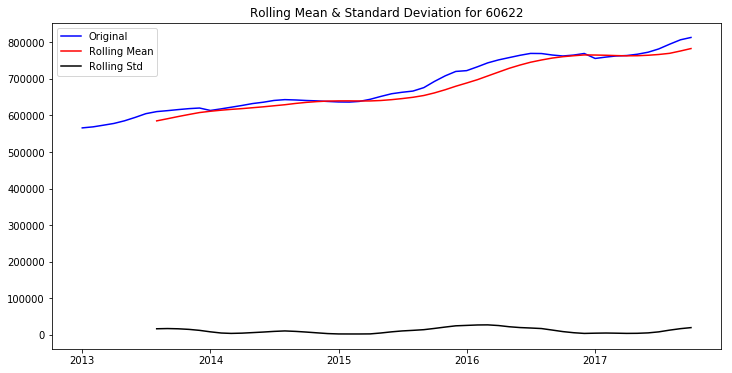

Results of Dickey-Fuller Test:
Test Statistic                 -0.194413
p-value                         0.939184
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


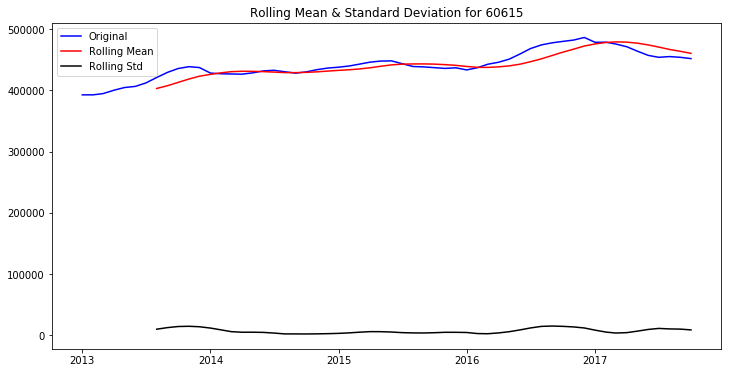

Results of Dickey-Fuller Test:
Test Statistic                 -2.518190
p-value                         0.111111
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


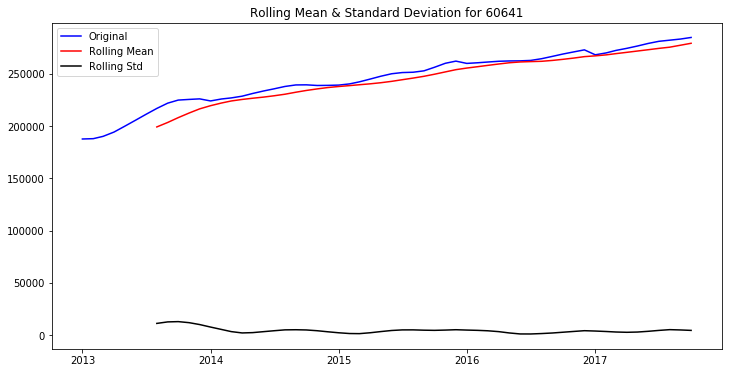

Results of Dickey-Fuller Test:
Test Statistic                 -2.518801
p-value                         0.110967
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


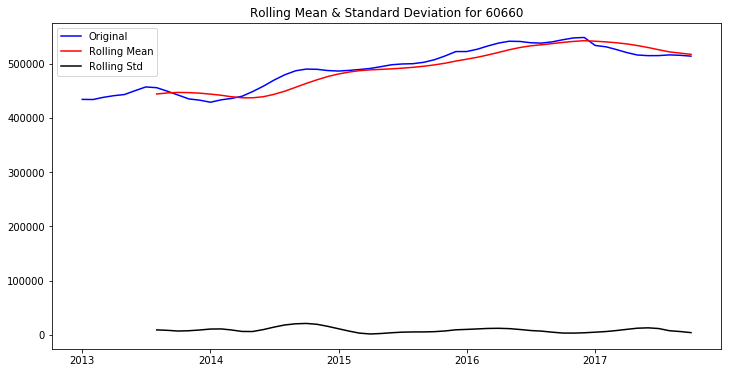

Results of Dickey-Fuller Test:
Test Statistic                 -1.664228
p-value                         0.449631
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


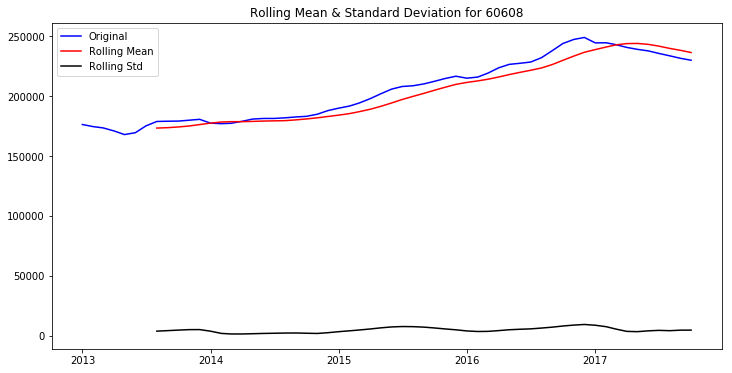

Results of Dickey-Fuller Test:
Test Statistic                 -1.181857
p-value                         0.681351
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


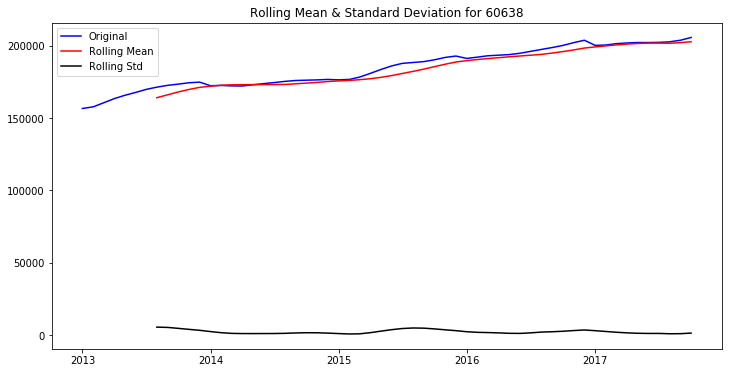

Results of Dickey-Fuller Test:
Test Statistic                 -1.300193
p-value                         0.629084
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


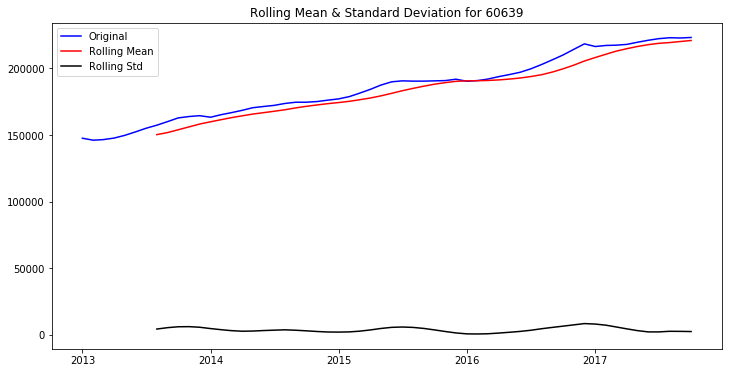

Results of Dickey-Fuller Test:
Test Statistic                 -1.099261
p-value                         0.715367
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


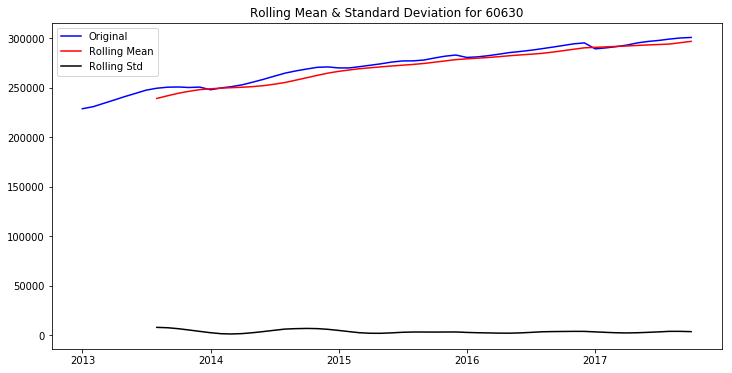

Results of Dickey-Fuller Test:
Test Statistic                 -3.389796
p-value                         0.011312
#Lags Used                     10.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


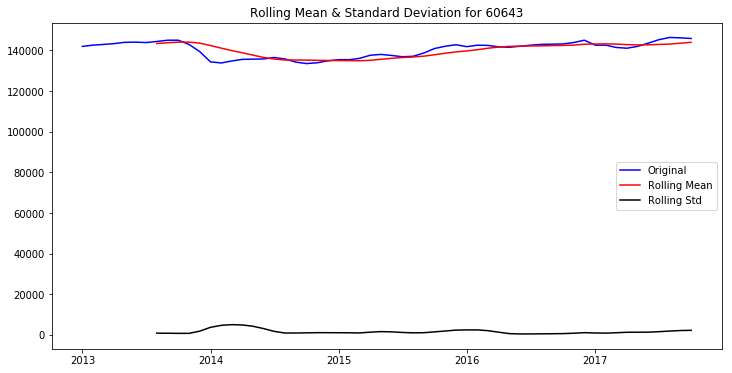

Results of Dickey-Fuller Test:
Test Statistic                 -2.048216
p-value                         0.265840
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


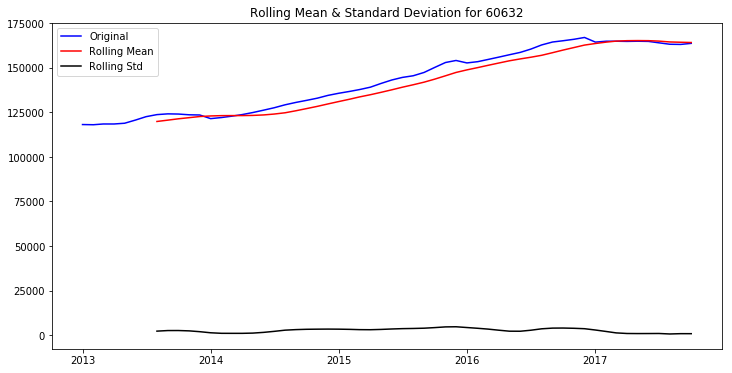

Results of Dickey-Fuller Test:
Test Statistic                 -0.933546
p-value                         0.776725
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


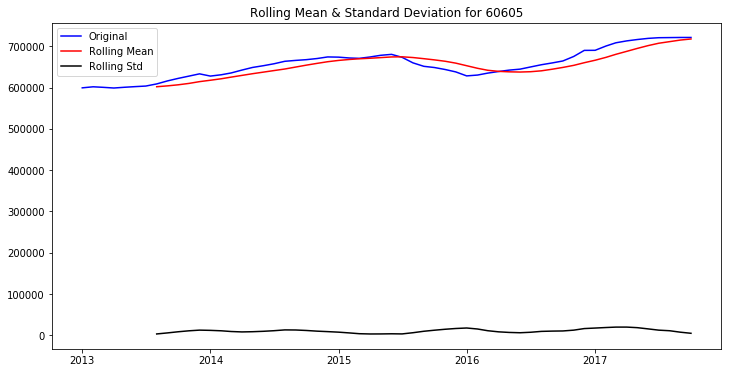

Results of Dickey-Fuller Test:
Test Statistic                 -0.996329
p-value                         0.754601
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


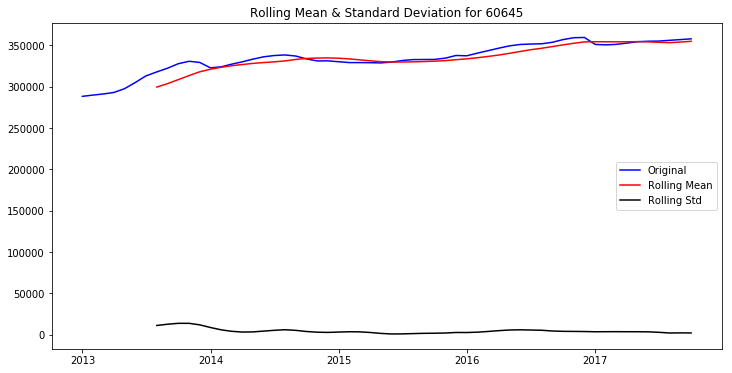

Results of Dickey-Fuller Test:
Test Statistic                 -2.474260
p-value                         0.121863
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


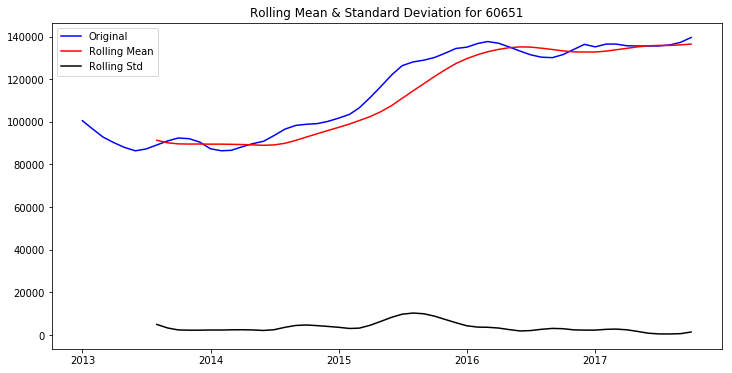

Results of Dickey-Fuller Test:
Test Statistic                 -0.750329
p-value                         0.833279
#Lags Used                      2.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


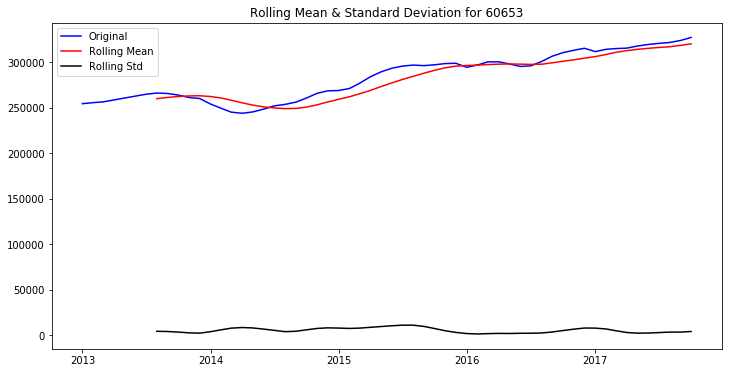

Results of Dickey-Fuller Test:
Test Statistic                 -0.268884
p-value                         0.929797
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


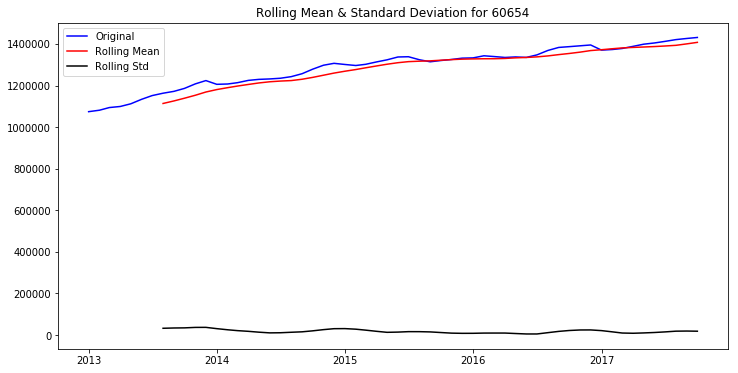

Results of Dickey-Fuller Test:
Test Statistic                 -2.480638
p-value                         0.120257
#Lags Used                      4.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


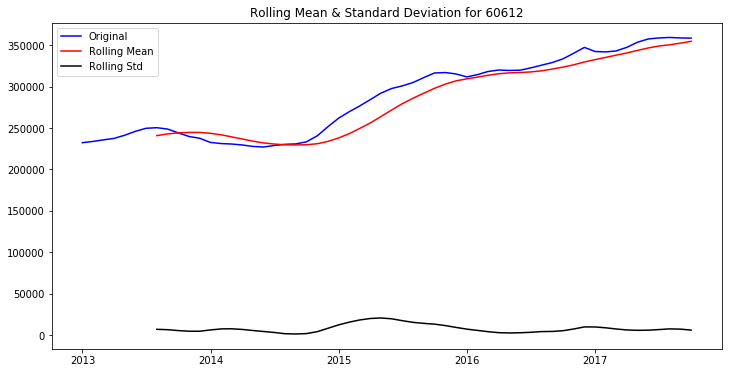

Results of Dickey-Fuller Test:
Test Statistic                 -0.637609
p-value                         0.862255
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


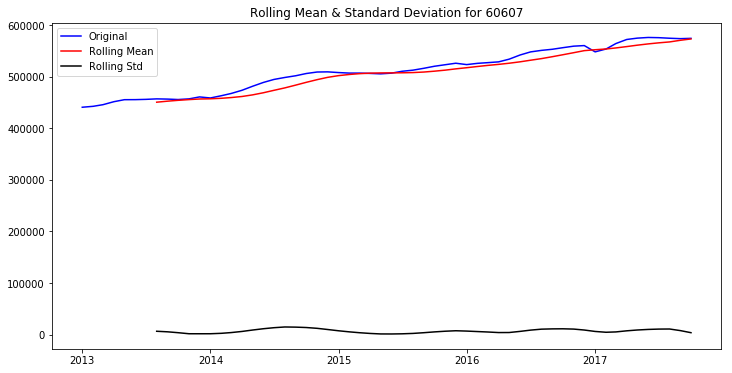

Results of Dickey-Fuller Test:
Test Statistic                 -0.839112
p-value                         0.807363
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


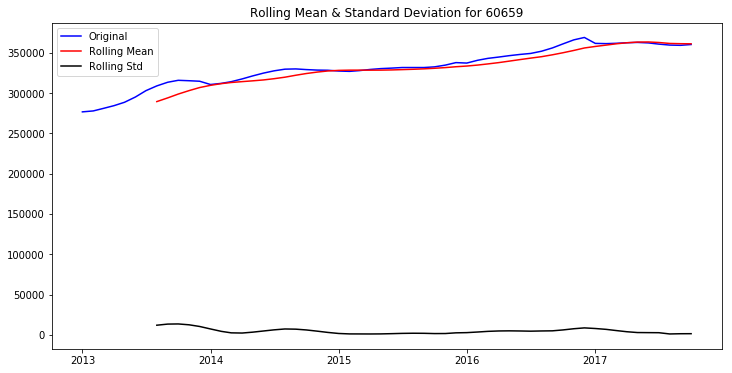

Results of Dickey-Fuller Test:
Test Statistic                 -2.425037
p-value                         0.134794
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


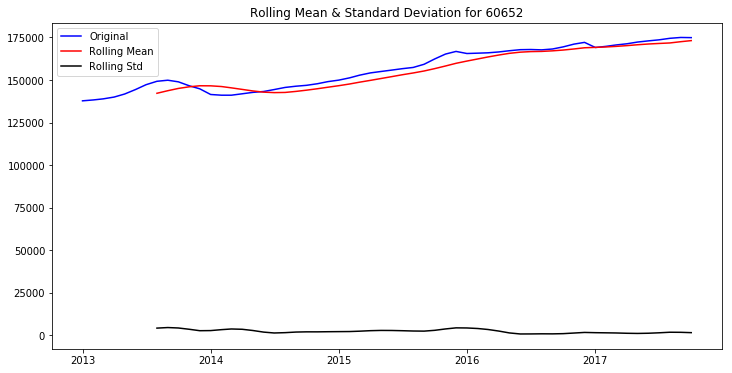

Results of Dickey-Fuller Test:
Test Statistic                 -0.915540
p-value                         0.782812
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


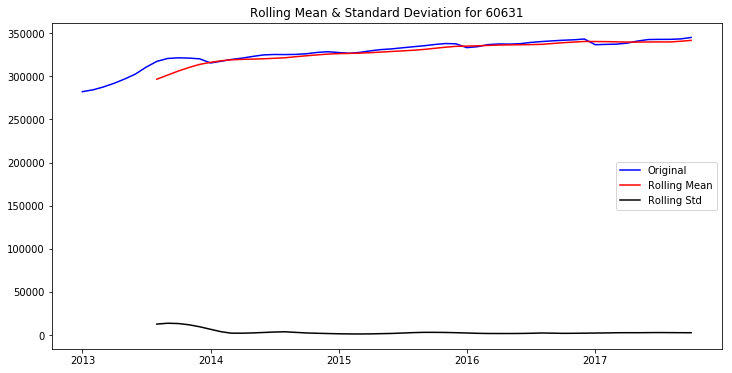

Results of Dickey-Fuller Test:
Test Statistic                 -2.383553
p-value                         0.146432
#Lags Used                      6.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64


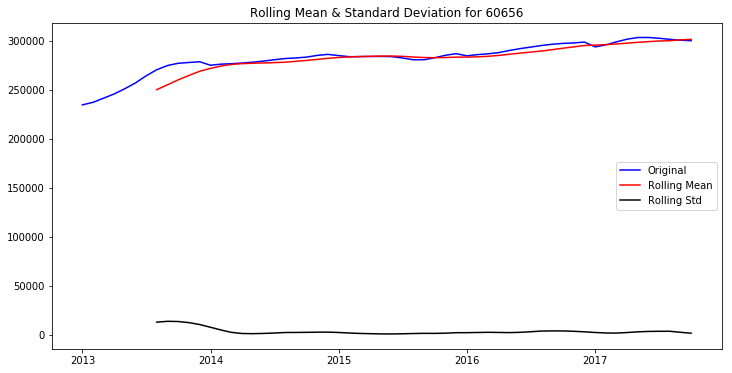

Results of Dickey-Fuller Test:
Test Statistic                 -3.533855
p-value                         0.007159
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


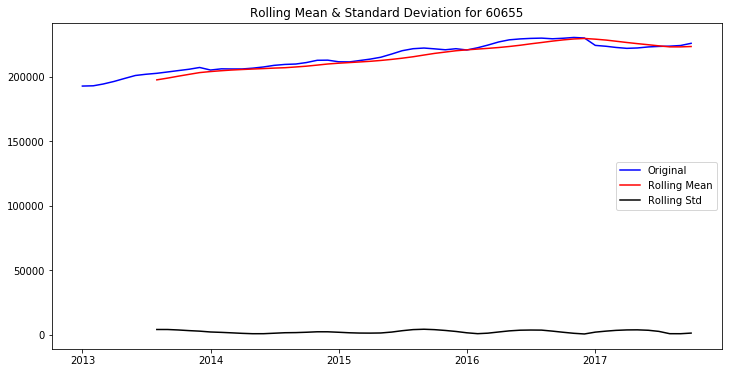

Results of Dickey-Fuller Test:
Test Statistic                 -2.109185
p-value                         0.240837
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


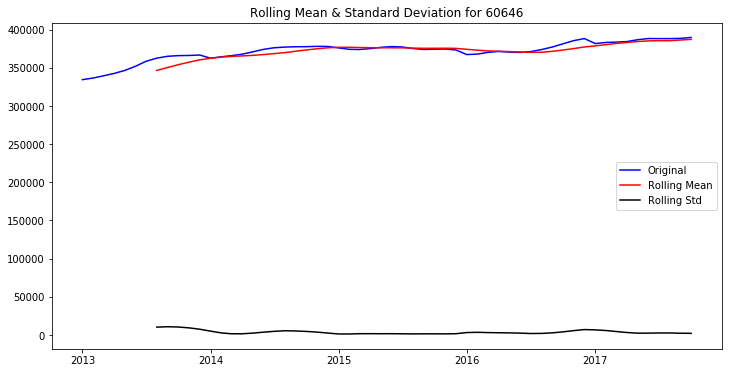

Results of Dickey-Fuller Test:
Test Statistic                 -2.821249
p-value                         0.055302
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


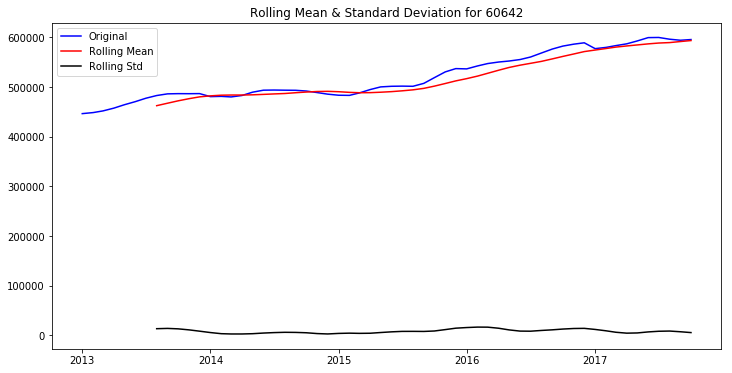

Results of Dickey-Fuller Test:
Test Statistic                 -0.652037
p-value                         0.858785
#Lags Used                      1.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


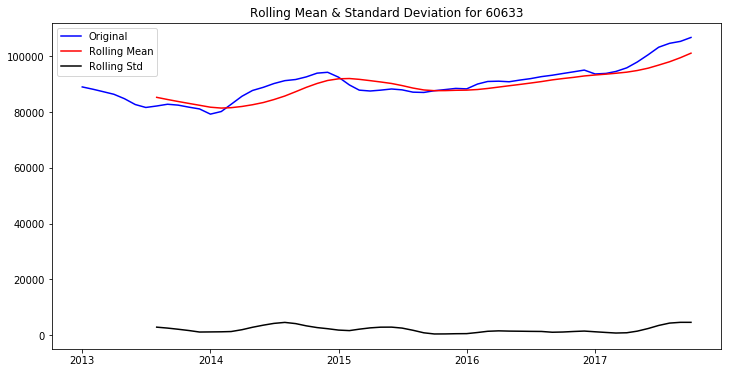

Results of Dickey-Fuller Test:
Test Statistic                  0.314198
p-value                         0.977987
#Lags Used                      2.000000
Number of Observations Used    55.000000
Critical Value (1%)            -3.555273
Critical Value (5%)            -2.915731
Critical Value (10%)           -2.595670
dtype: float64


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [29]:
[stationarity_check(zillow_chicago_train,x) for x in list(zillow_chicago_train.columns)]

Trend in the mean, variance is fairly close to zero and is constant. 

## Removing trend and seasonality

In [30]:



def detrend(TS, alpha=0.05):
    
    '''Selecting the best method for detrending timeseries based on 
        lowest p-value of the augmented Dickey-Fuller.
        TS: timeseries dataframe
        alpha: alpha value for Dickey-Fuller '''
    
    new_TS = pd.DataFrame()
    
    plist = []
    for column in list(TS.columns):

        p_values = []
        # zipcode 60611 has NaN, so we can't detrend
        if column==60611:
            pass
        else:

            decomposition=seasonal_decompose(TS[column].dropna())
            residuals = decomposition.resid
            dftest = adfuller(residuals.dropna(),maxlag=4)
            dfoutput1 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
            for key, value in dftest[4].items():
                dfoutput1['Critical Values (%s)' %key] = value
            p_values.append(dfoutput1[1])


            data_diff1 = TS[column].diff(periods=1)
            dftest = adfuller(data_diff1.dropna(),maxlag=4)
            dfoutput2 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
            for key, value in dftest[4].items():
                dfoutput2['Critical Values (%s)' %key] = value
            p_values.append(dfoutput2[1])

            data_diff2 = TS[column].apply(lambda x: np.log(x)) - TS[column].apply(lambda x: np.log(x)).shift(1)
            dftest = adfuller(data_diff2.dropna(),maxlag=4)
            dfoutput3 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
            for key, value in dftest[4].items():
                dfoutput3['Critical Values (%s)' %key] = value
            p_values.append(dfoutput3[1])


            temp_diff = TS[column].apply(lambda x: np.log(x)) - TS[column].apply(lambda x: np.log(x)).shift(1)
            data_diff3 = temp_diff - temp_diff.shift(12)  
            dftest = adfuller(data_diff3.dropna(),maxlag=4)
            dfoutput4 = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
            for key, value in dftest[4].items():
                dfoutput4['Critical Values (%s)' %key] = value
            p_values.append(dfoutput4[1])

            if np.argmin(p_values)==0:
                residuals.plot(figsize=(20,6))
                plt.title('{} Seasonal Decomposition'.format(column))
                plt.show();
                print(dfoutput1)
                new_TS[column]=residuals

            elif np.argmin(p_values)==1:
                data_diff1.plot(figsize=(20,6))
                plt.title('{} First Difference'.format(column))
                plt.show();
                print(dfoutput2)
                new_TS[column]=data_diff1

            elif np.argmin(p_values)==2:
                data_diff2.plot(figsize=(20,6))
                plt.title('{} Log First Difference'.format(column))
                plt.show();
                print(dfoutput3)
                new_TS[column]=data_diff2

            elif np.argmin(p_values)==3:
                data_diff3.plot(figsize=(20,6))
                plt.title('{} Log Seasonal First Difference'.format(column))
                plt.show();
                print(dfoutput4)
                new_TS[column]=data_diff3

            plist.append(min(p_values))
    print('\n','The p-value above {}:'.format(alpha),(np.array(plist)>alpha).sum())
    return new_TS
  
    

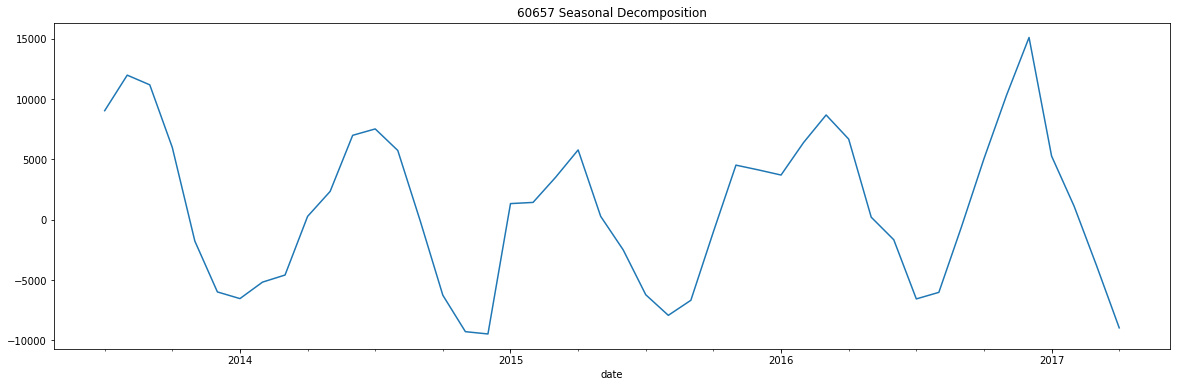

Test Statistic                -5.831427e+00
p-value                        3.966776e-07
#Lags Used                     3.000000e+00
Number of Observations Used    4.200000e+01
Critical Values (1%)          -3.596636e+00
Critical Values (5%)          -2.933297e+00
Critical Values (10%)         -2.604991e+00
dtype: float64


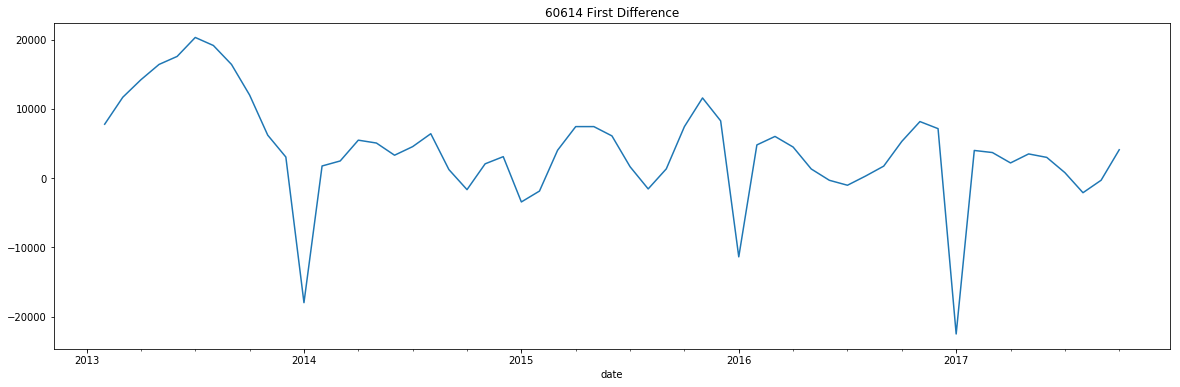

Test Statistic                 -4.604443
p-value                         0.000127
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


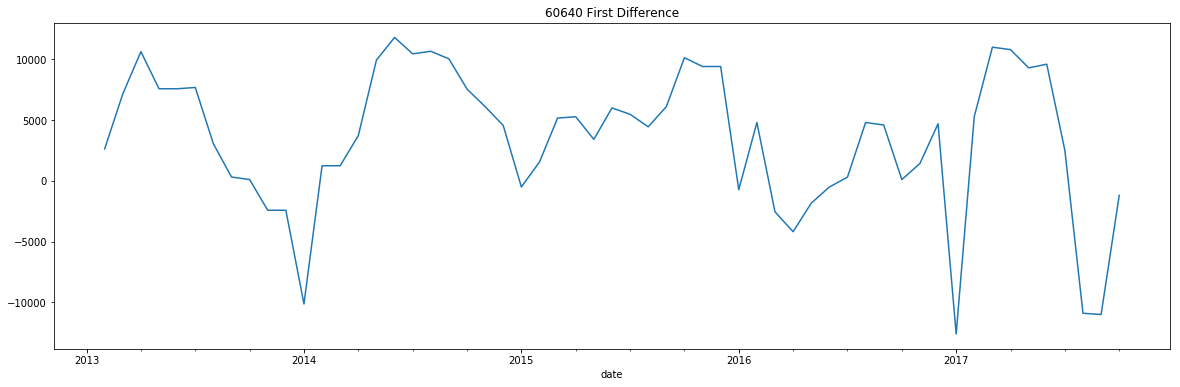

Test Statistic                 -4.581580
p-value                         0.000140
#Lags Used                      4.000000
Number of Observations Used    52.000000
Critical Values (1%)           -3.562879
Critical Values (5%)           -2.918973
Critical Values (10%)          -2.597393
dtype: float64


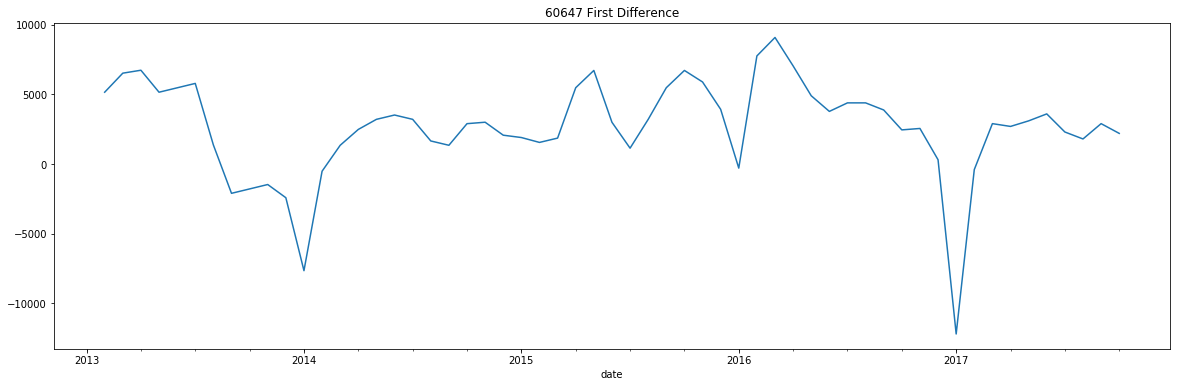

Test Statistic                 -3.892460
p-value                         0.002091
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


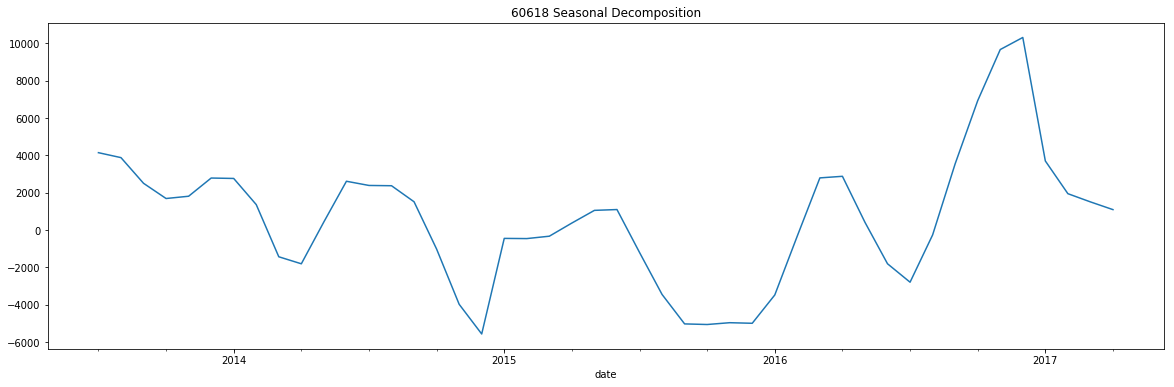

Test Statistic                 -3.850666
p-value                         0.002429
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Values (1%)           -3.588573
Critical Values (5%)           -2.929886
Critical Values (10%)          -2.603185
dtype: float64


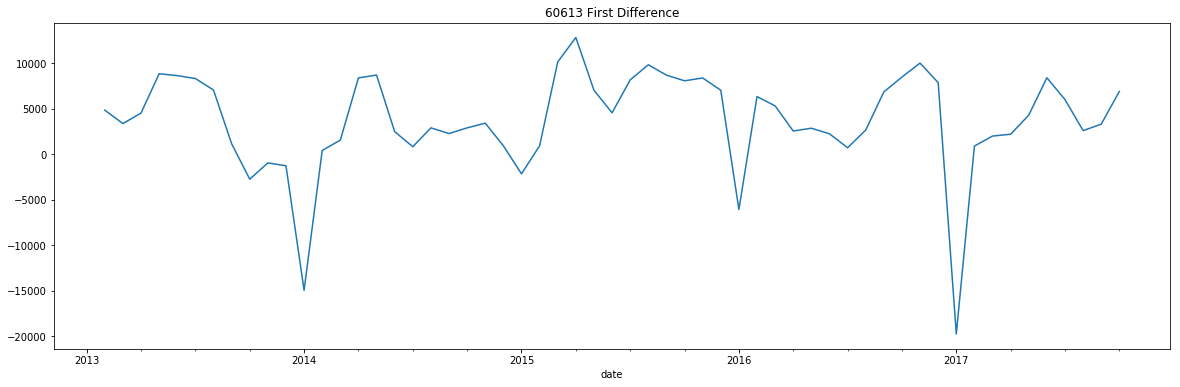

Test Statistic                 -5.304533
p-value                         0.000005
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


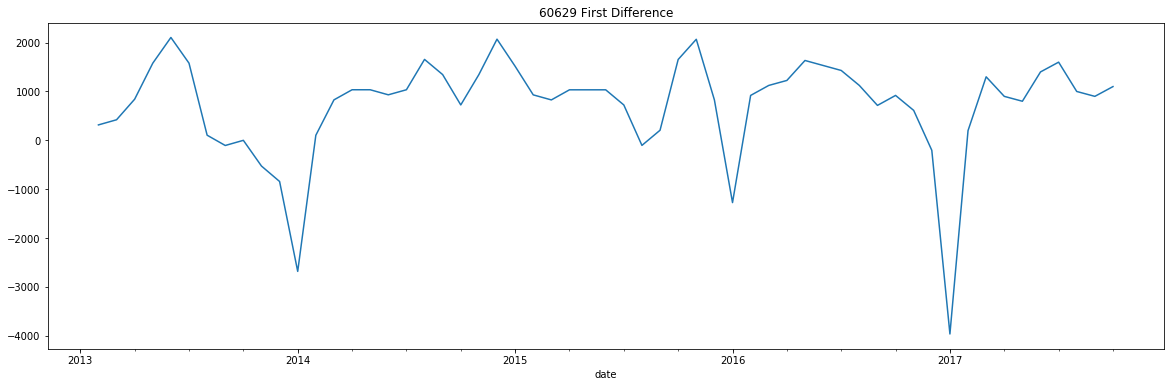

Test Statistic                 -4.518347
p-value                         0.000182
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


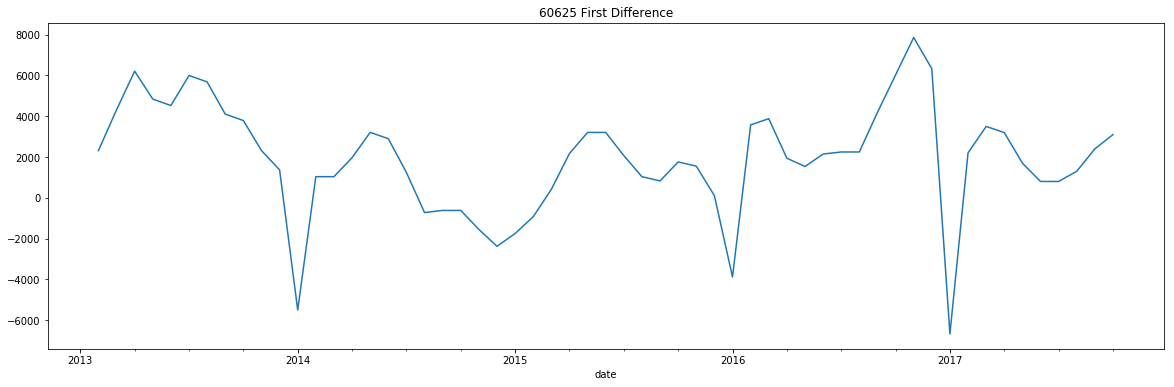

Test Statistic                 -4.586233
p-value                         0.000137
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


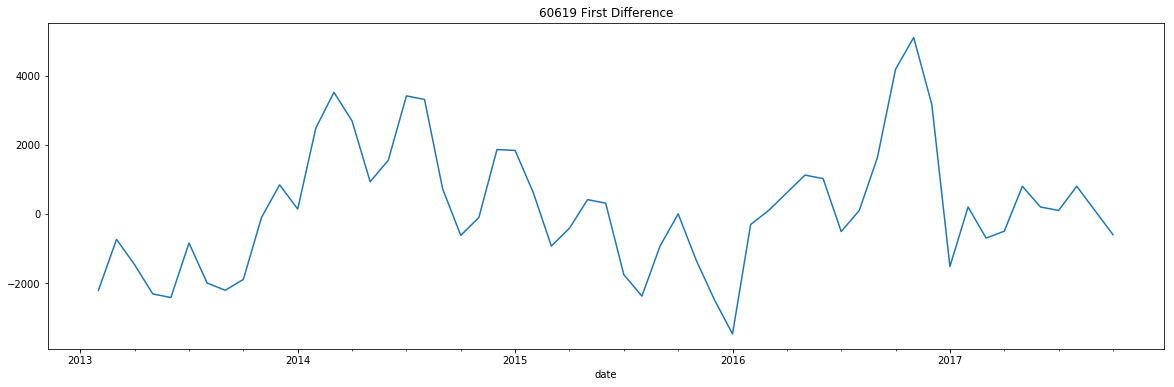

Test Statistic                 -2.787158
p-value                         0.060132
#Lags Used                      2.000000
Number of Observations Used    54.000000
Critical Values (1%)           -3.557709
Critical Values (5%)           -2.916770
Critical Values (10%)          -2.596222
dtype: float64


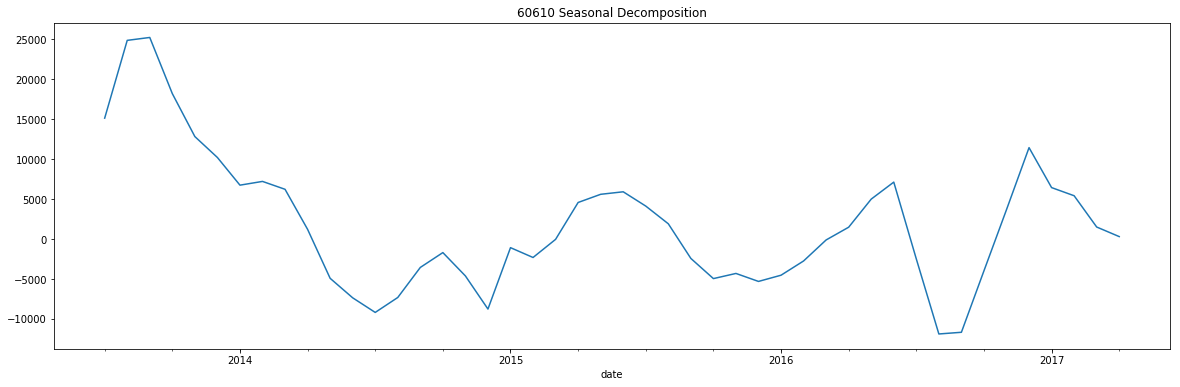

Test Statistic                 -4.390642
p-value                         0.000308
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Values (1%)           -3.588573
Critical Values (5%)           -2.929886
Critical Values (10%)          -2.603185
dtype: float64


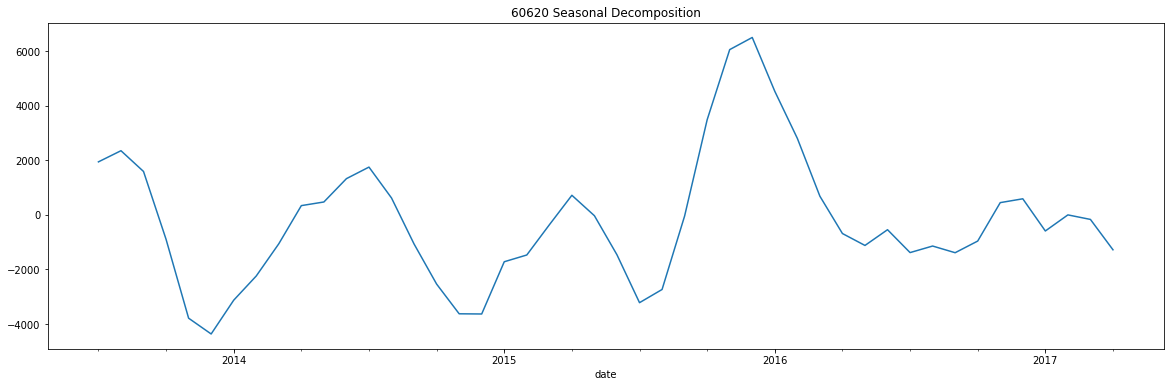

Test Statistic                 -5.301946
p-value                         0.000005
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Values (1%)           -3.588573
Critical Values (5%)           -2.929886
Critical Values (10%)          -2.603185
dtype: float64


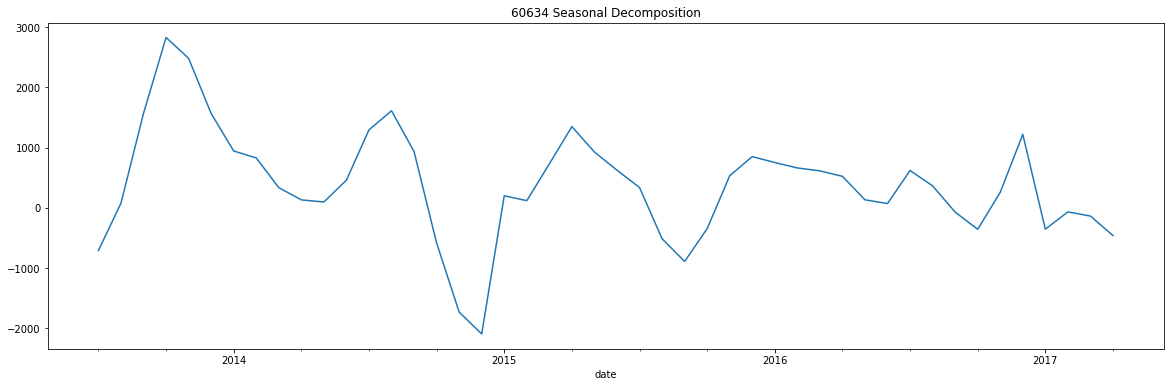

Test Statistic                 -4.354573
p-value                         0.000357
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Values (1%)           -3.588573
Critical Values (5%)           -2.929886
Critical Values (10%)          -2.603185
dtype: float64


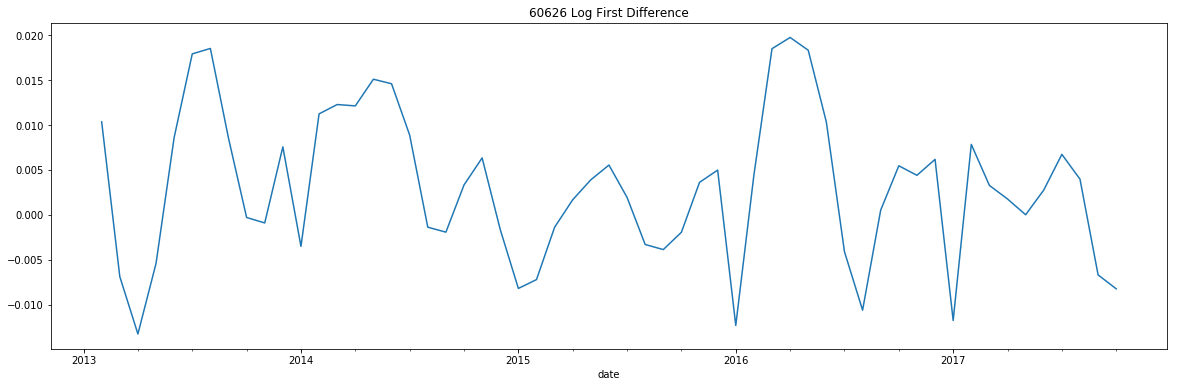

Test Statistic                 -4.961524
p-value                         0.000026
#Lags Used                      1.000000
Number of Observations Used    55.000000
Critical Values (1%)           -3.555273
Critical Values (5%)           -2.915731
Critical Values (10%)          -2.595670
dtype: float64


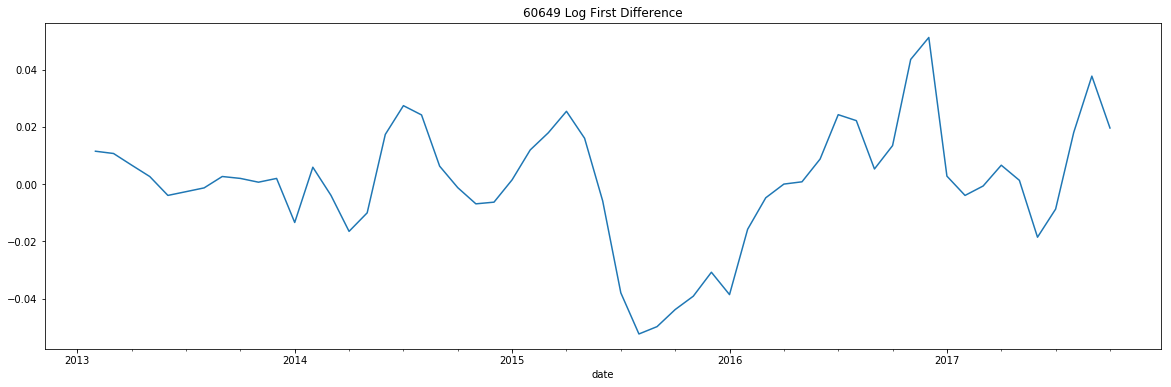

Test Statistic                 -2.848996
p-value                         0.051609
#Lags Used                      4.000000
Number of Observations Used    52.000000
Critical Values (1%)           -3.562879
Critical Values (5%)           -2.918973
Critical Values (10%)          -2.597393
dtype: float64


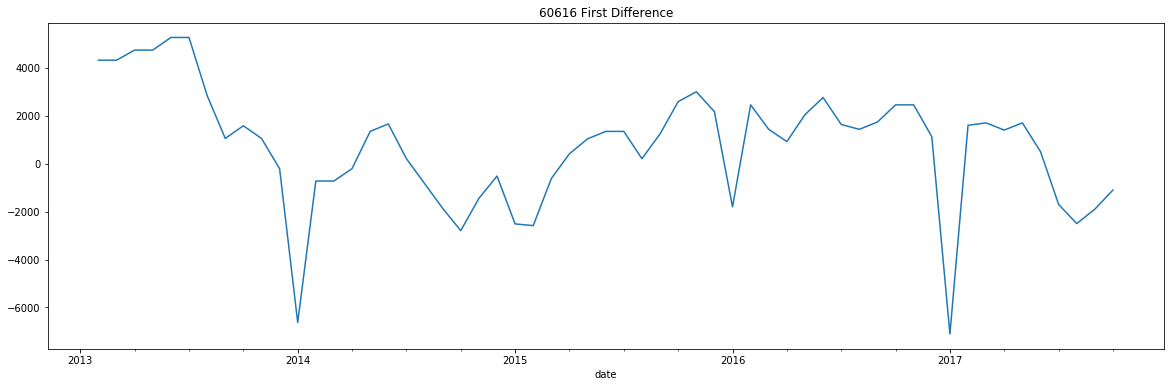

Test Statistic                 -4.101448
p-value                         0.000963
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


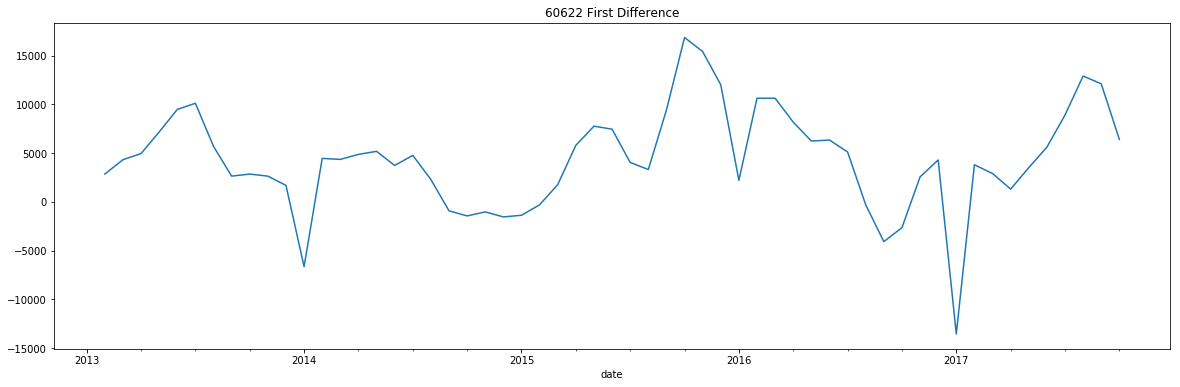

Test Statistic                 -3.901008
p-value                         0.002027
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


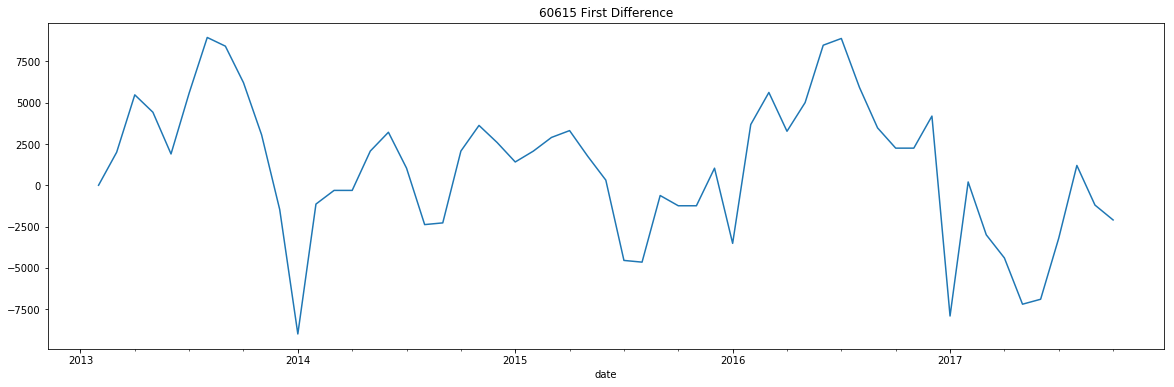

Test Statistic                 -3.401486
p-value                         0.010908
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


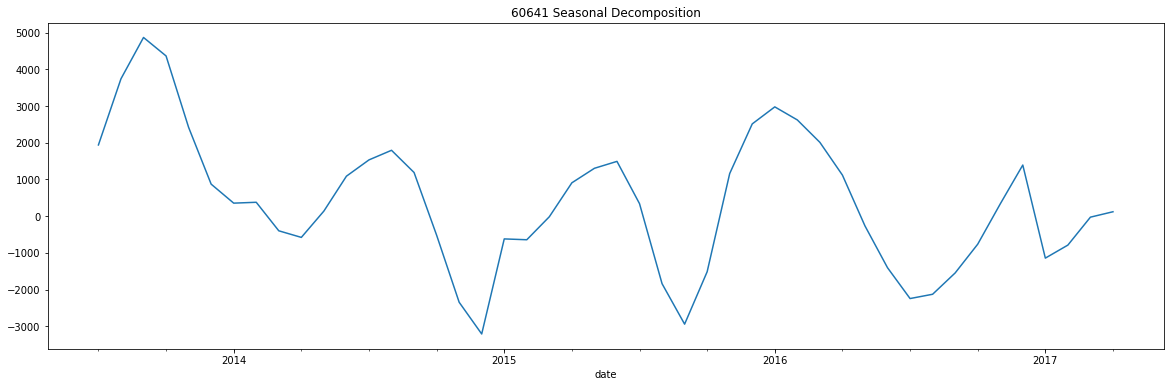

Test Statistic                 -4.759576
p-value                         0.000065
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Values (1%)           -3.588573
Critical Values (5%)           -2.929886
Critical Values (10%)          -2.603185
dtype: float64


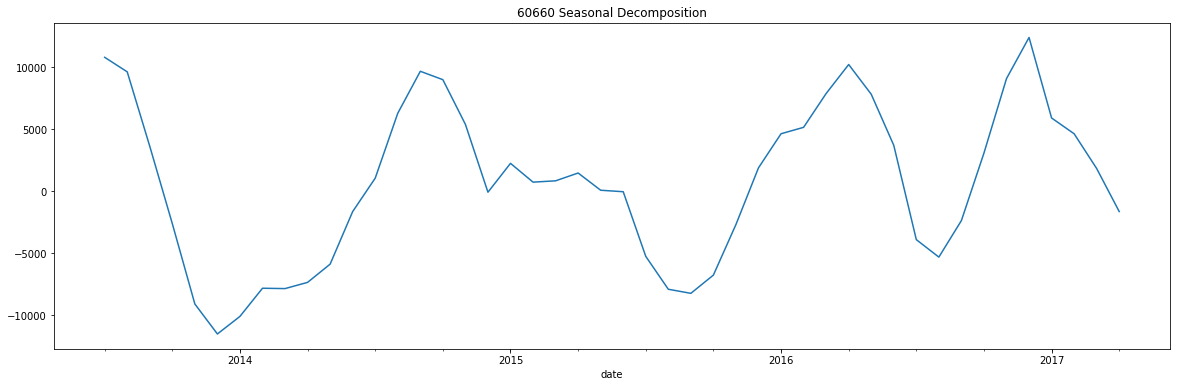

Test Statistic                 -4.493599
p-value                         0.000202
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Values (1%)           -3.588573
Critical Values (5%)           -2.929886
Critical Values (10%)          -2.603185
dtype: float64


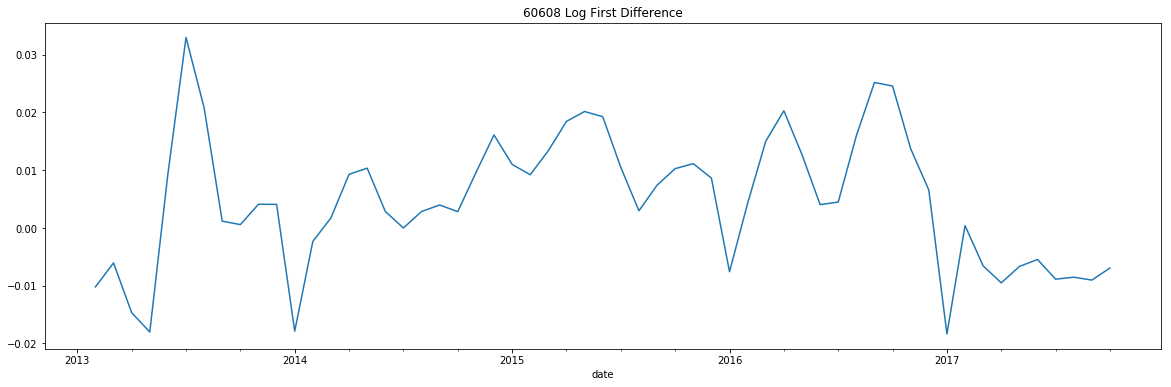

Test Statistic                 -4.096827
p-value                         0.000980
#Lags Used                      1.000000
Number of Observations Used    55.000000
Critical Values (1%)           -3.555273
Critical Values (5%)           -2.915731
Critical Values (10%)          -2.595670
dtype: float64


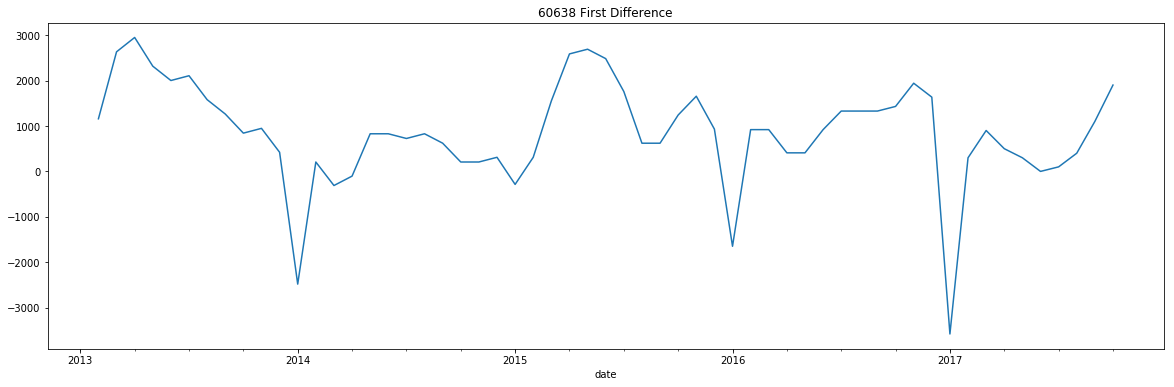

Test Statistic                 -4.653187
p-value                         0.000103
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


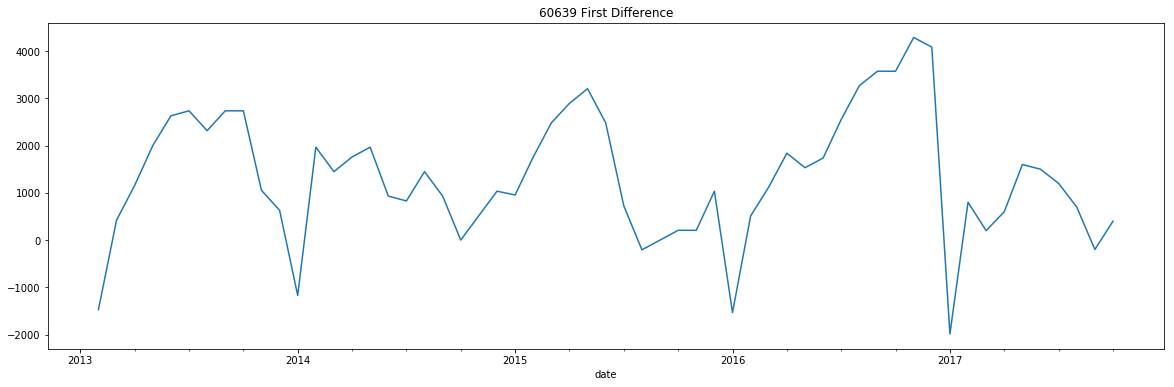

Test Statistic                 -4.416023
p-value                         0.000278
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


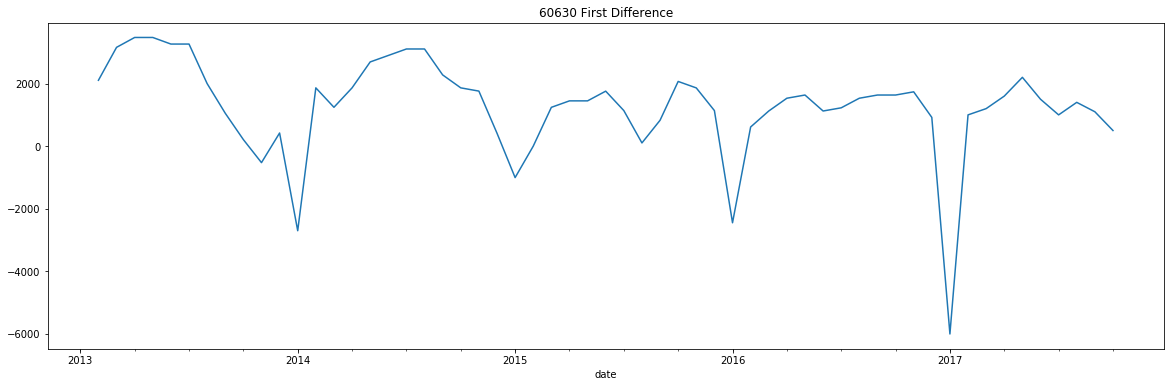

Test Statistic                 -4.982200
p-value                         0.000024
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


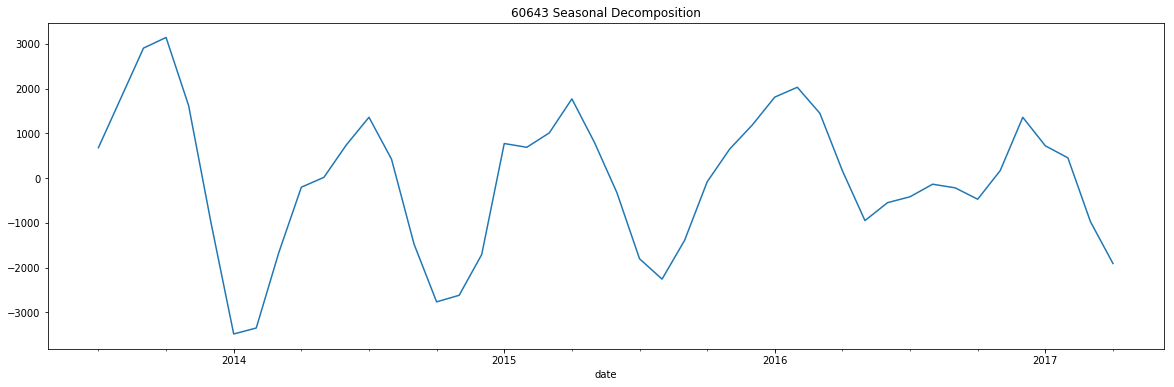

Test Statistic                -6.371549e+00
p-value                        2.338356e-08
#Lags Used                     1.000000e+00
Number of Observations Used    4.400000e+01
Critical Values (1%)          -3.588573e+00
Critical Values (5%)          -2.929886e+00
Critical Values (10%)         -2.603185e+00
dtype: float64


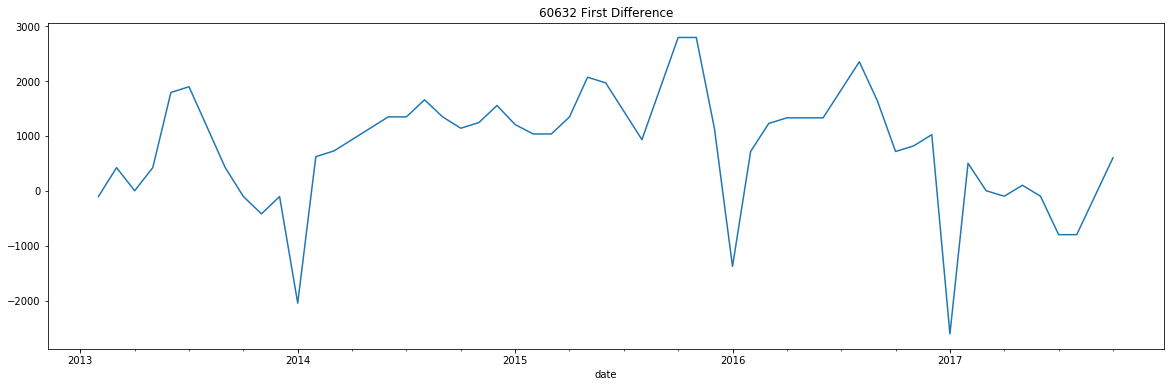

Test Statistic                 -4.185347
p-value                         0.000698
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


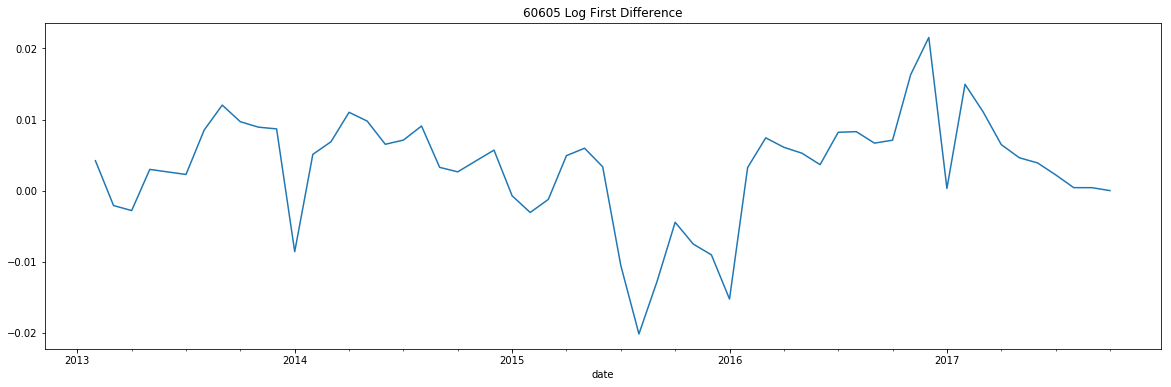

Test Statistic                 -3.567568
p-value                         0.006412
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


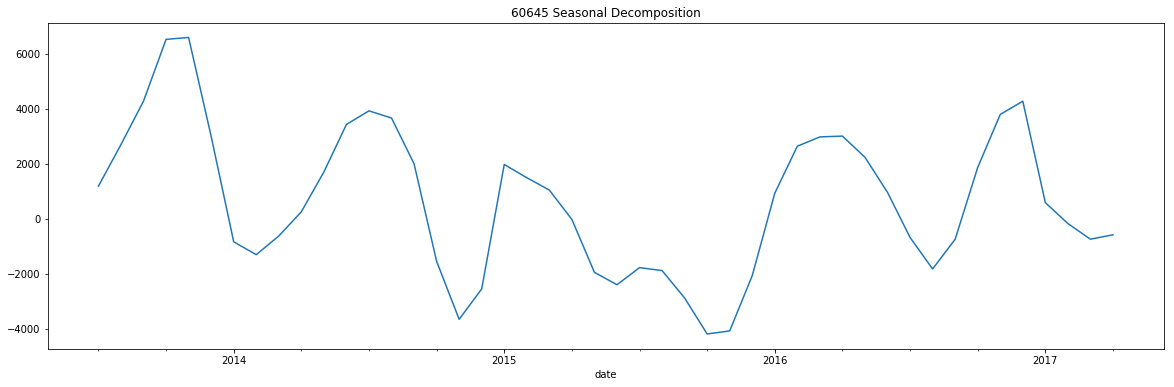

Test Statistic                 -5.132427
p-value                         0.000012
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Values (1%)           -3.588573
Critical Values (5%)           -2.929886
Critical Values (10%)          -2.603185
dtype: float64


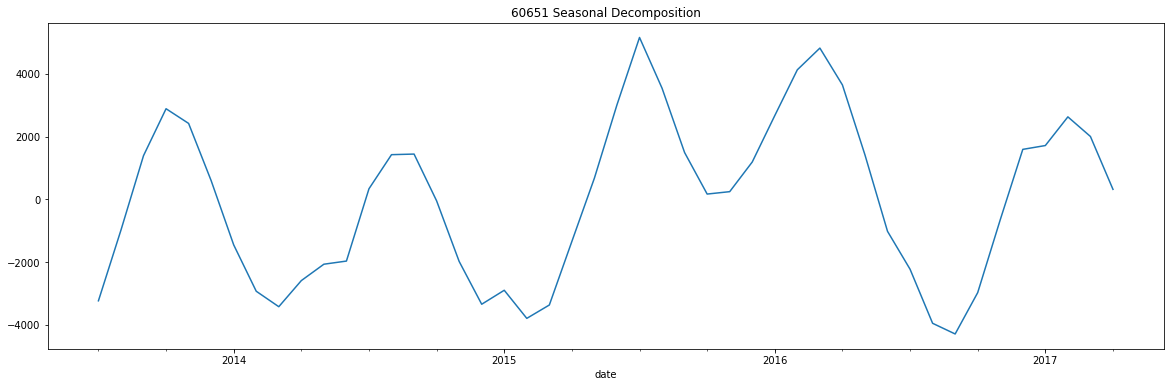

Test Statistic                -5.690771e+00
p-value                        8.081072e-07
#Lags Used                     1.000000e+00
Number of Observations Used    4.400000e+01
Critical Values (1%)          -3.588573e+00
Critical Values (5%)          -2.929886e+00
Critical Values (10%)         -2.603185e+00
dtype: float64


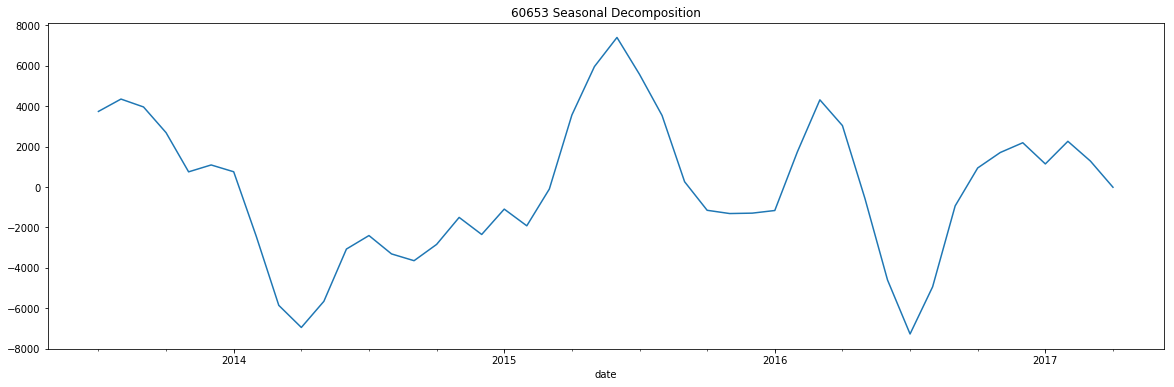

Test Statistic                 -4.519623
p-value                         0.000181
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Values (1%)           -3.588573
Critical Values (5%)           -2.929886
Critical Values (10%)          -2.603185
dtype: float64


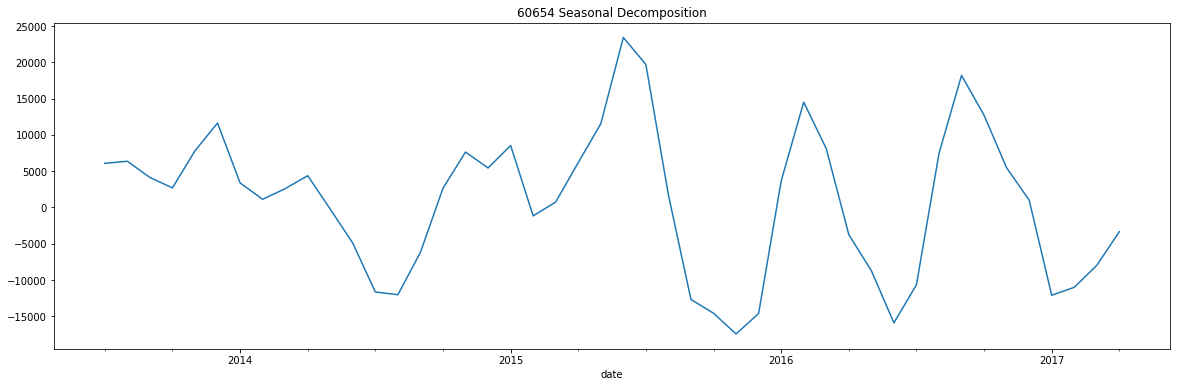

Test Statistic                -5.934510e+00
p-value                        2.338105e-07
#Lags Used                     1.000000e+00
Number of Observations Used    4.400000e+01
Critical Values (1%)          -3.588573e+00
Critical Values (5%)          -2.929886e+00
Critical Values (10%)         -2.603185e+00
dtype: float64


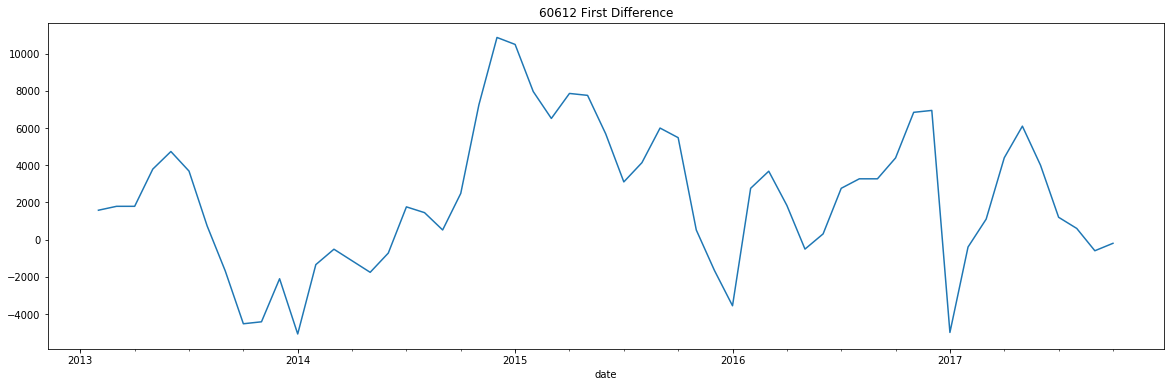

Test Statistic                 -3.222260
p-value                         0.018732
#Lags Used                      1.000000
Number of Observations Used    55.000000
Critical Values (1%)           -3.555273
Critical Values (5%)           -2.915731
Critical Values (10%)          -2.595670
dtype: float64


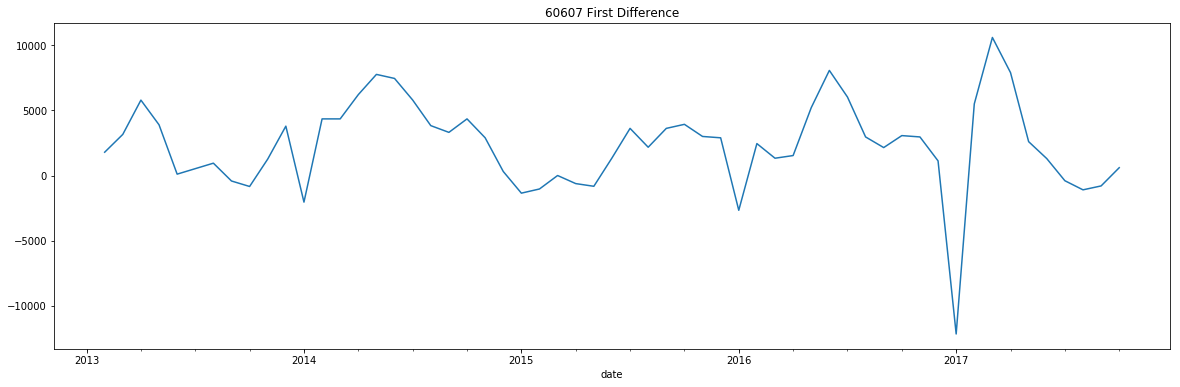

Test Statistic                 -4.883302
p-value                         0.000038
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


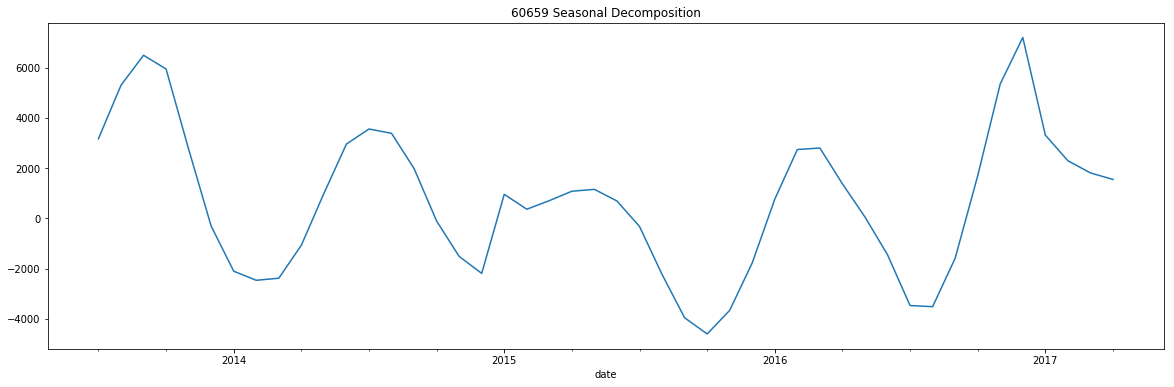

Test Statistic                 -5.574939
p-value                         0.000001
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Values (1%)           -3.588573
Critical Values (5%)           -2.929886
Critical Values (10%)          -2.603185
dtype: float64


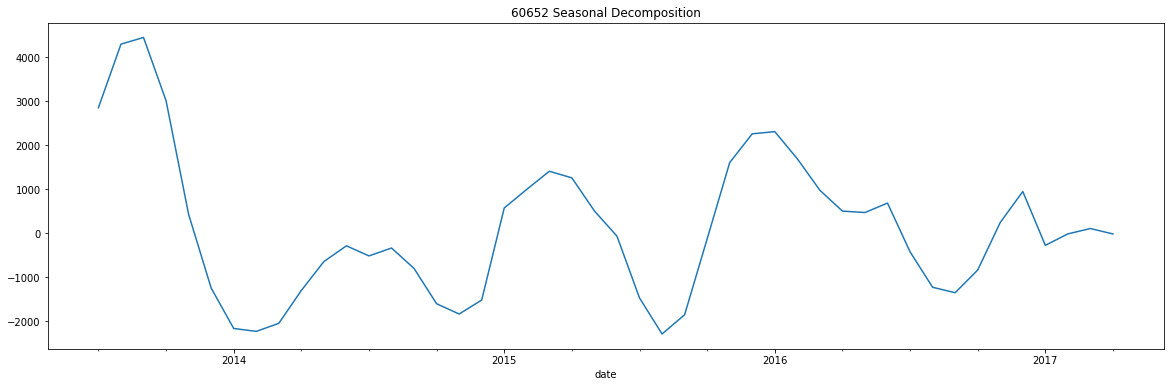

Test Statistic                -6.153441e+00
p-value                        7.466260e-08
#Lags Used                     1.000000e+00
Number of Observations Used    4.400000e+01
Critical Values (1%)          -3.588573e+00
Critical Values (5%)          -2.929886e+00
Critical Values (10%)         -2.603185e+00
dtype: float64


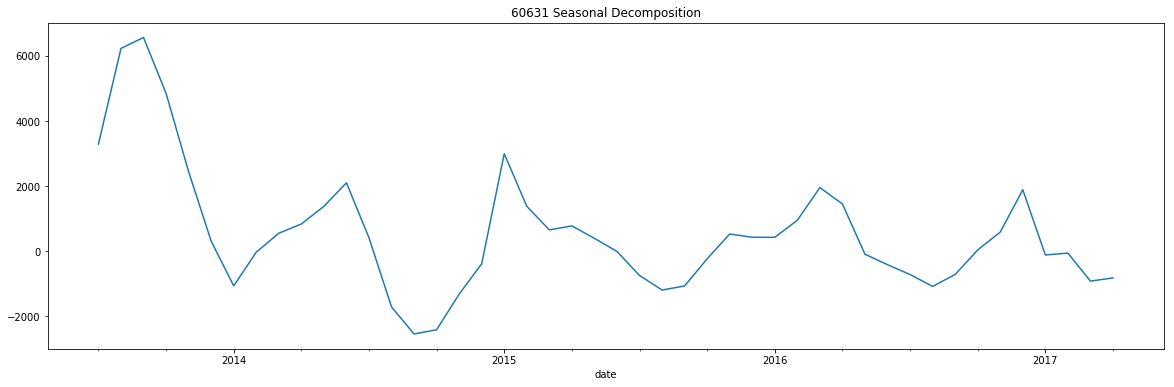

Test Statistic                 -5.495120
p-value                         0.000002
#Lags Used                      2.000000
Number of Observations Used    43.000000
Critical Values (1%)           -3.592504
Critical Values (5%)           -2.931550
Critical Values (10%)          -2.604066
dtype: float64


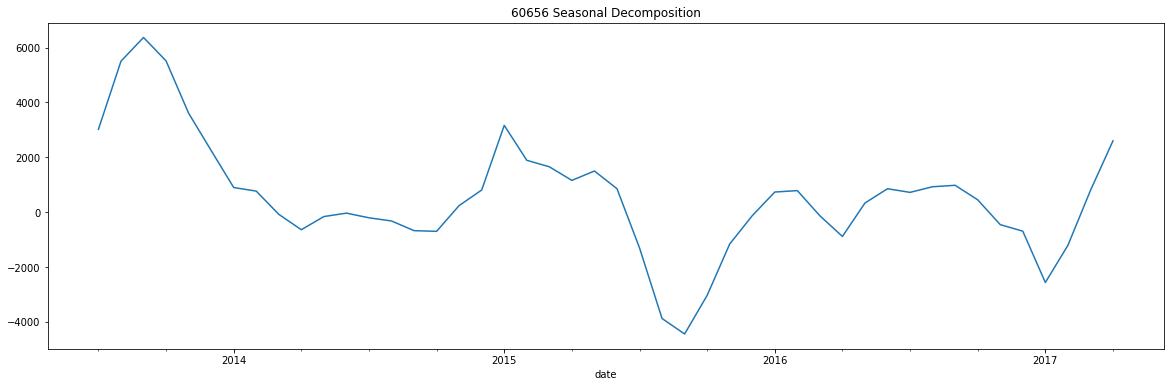

Test Statistic                 -4.159639
p-value                         0.000771
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Values (1%)           -3.588573
Critical Values (5%)           -2.929886
Critical Values (10%)          -2.603185
dtype: float64


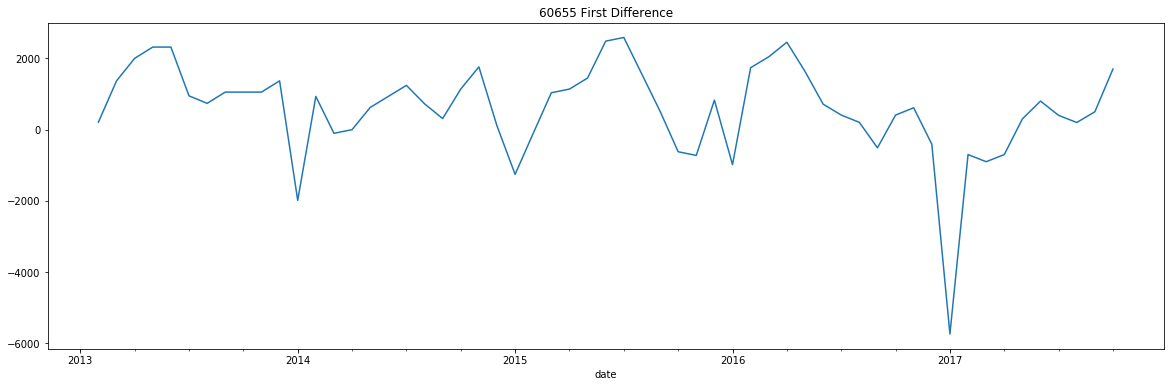

Test Statistic                 -4.681139
p-value                         0.000091
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Values (1%)           -3.552928
Critical Values (5%)           -2.914731
Critical Values (10%)          -2.595137
dtype: float64


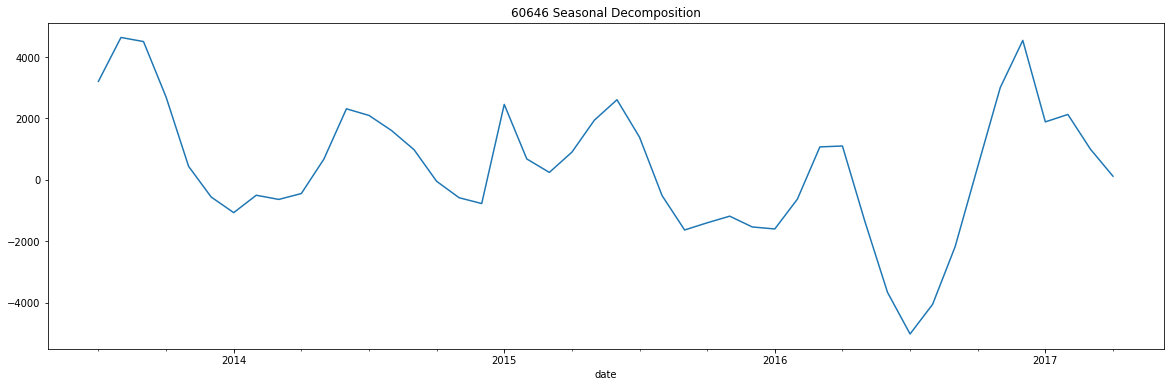

Test Statistic                 -4.520323
p-value                         0.000181
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Values (1%)           -3.588573
Critical Values (5%)           -2.929886
Critical Values (10%)          -2.603185
dtype: float64


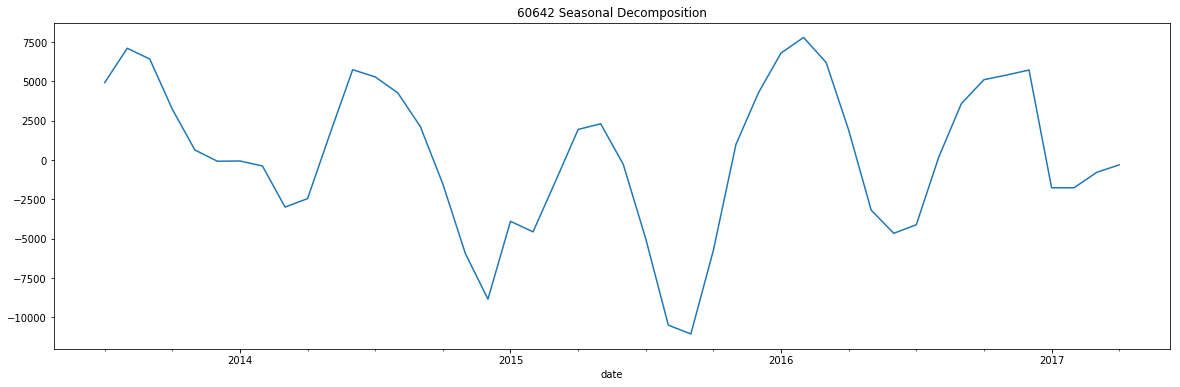

Test Statistic                 -5.391633
p-value                         0.000004
#Lags Used                      1.000000
Number of Observations Used    44.000000
Critical Values (1%)           -3.588573
Critical Values (5%)           -2.929886
Critical Values (10%)          -2.603185
dtype: float64


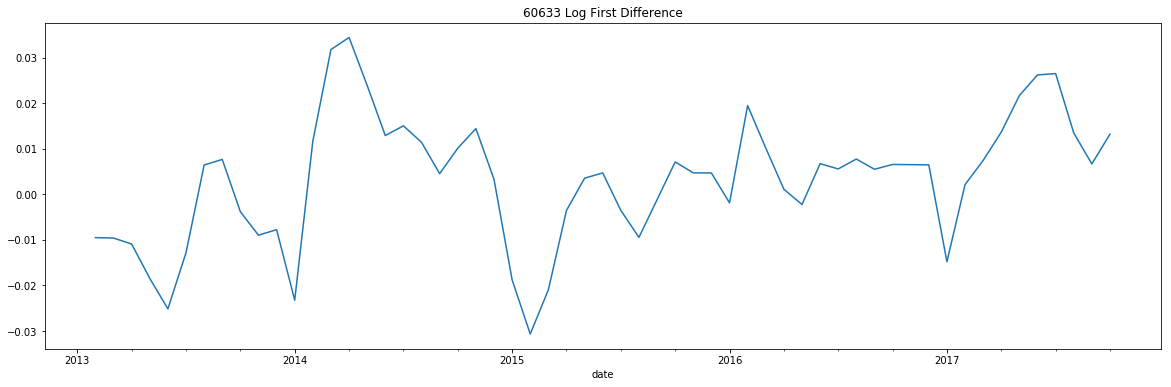

Test Statistic                 -3.942979
p-value                         0.001740
#Lags Used                      1.000000
Number of Observations Used    55.000000
Critical Values (1%)           -3.555273
Critical Values (5%)           -2.915731
Critical Values (10%)          -2.595670
dtype: float64

 The p-value above 0.05: 2


In [31]:

zc_train_dt = detrend(zillow_chicago_train,0.05)

The nan's are because we took the differences (sometimes twice). 

In [39]:
def ACF_PACF(TS, lags):
    for column in list(TS.columns):
        print(column)
        rcParams['figure.figsize']=14,5
        plot_acf(TS[column])
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.show()
        rcParams['figure.figsize']=14,5
        plot_pacf(TS[column], lags=lags)
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        plt.show()
        print('_____________________________________________________________________')

60657


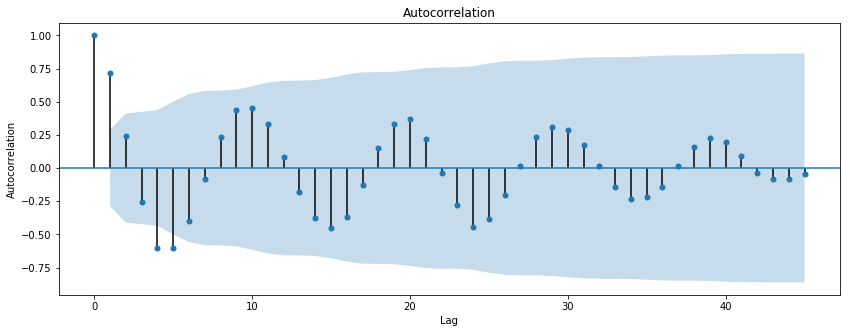

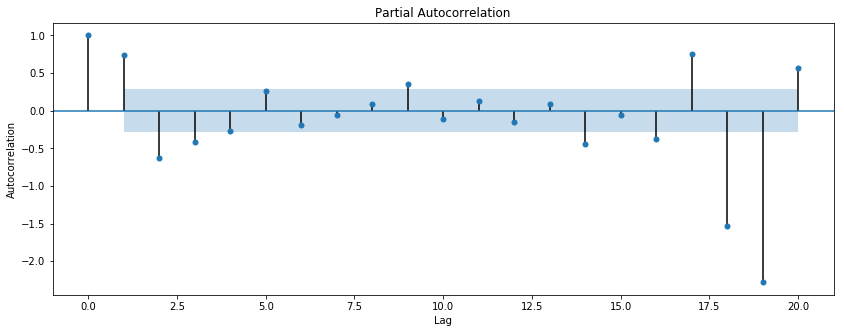

_____________________________________________________________________
60614


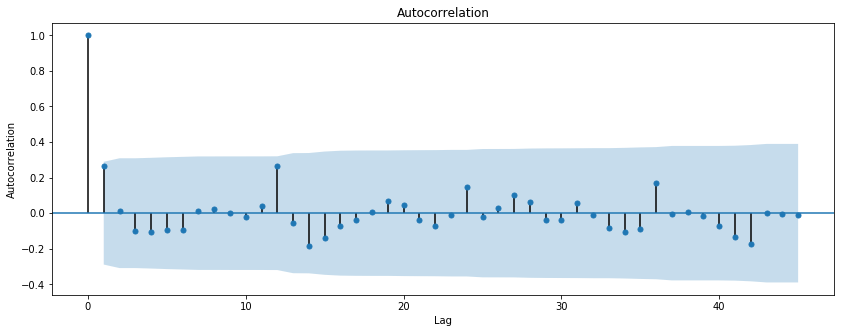

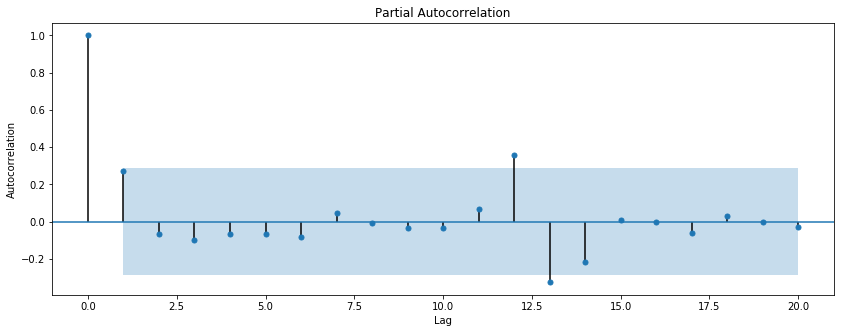

_____________________________________________________________________
60640


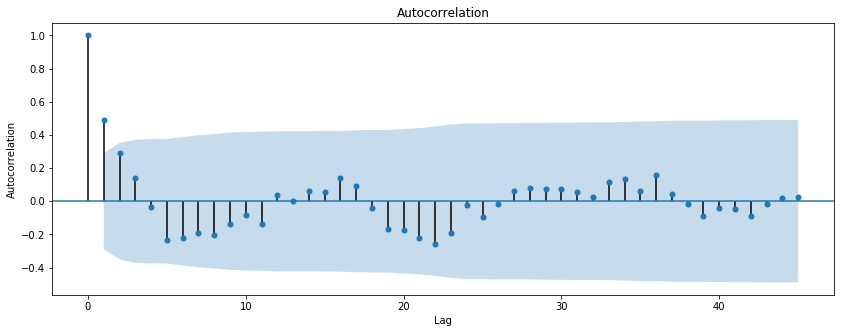

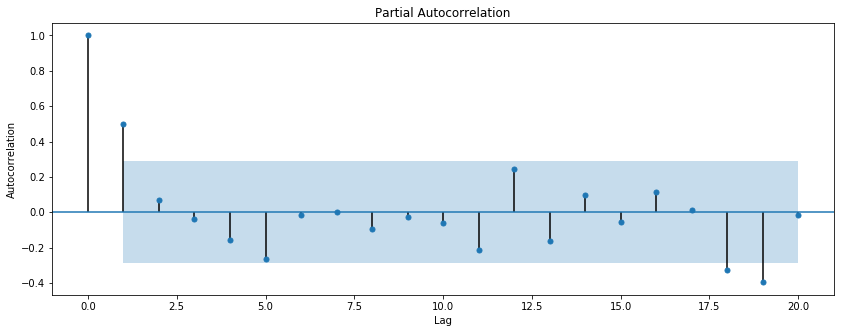

_____________________________________________________________________
60647


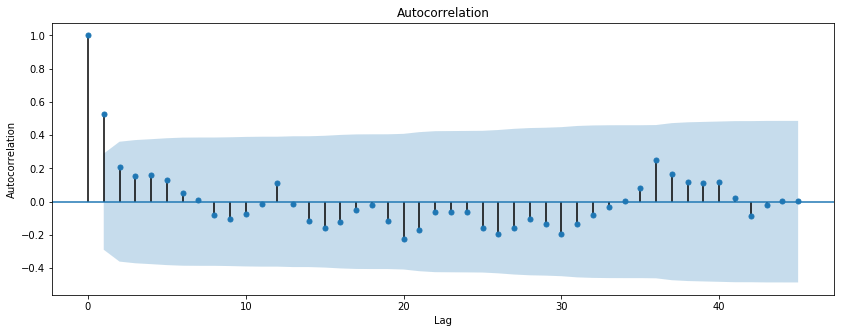

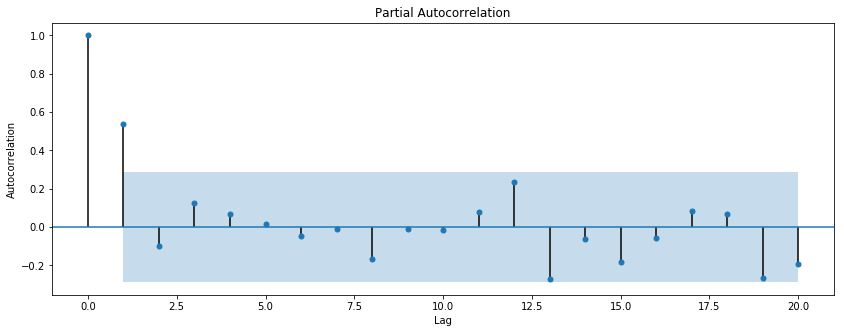

_____________________________________________________________________
60618


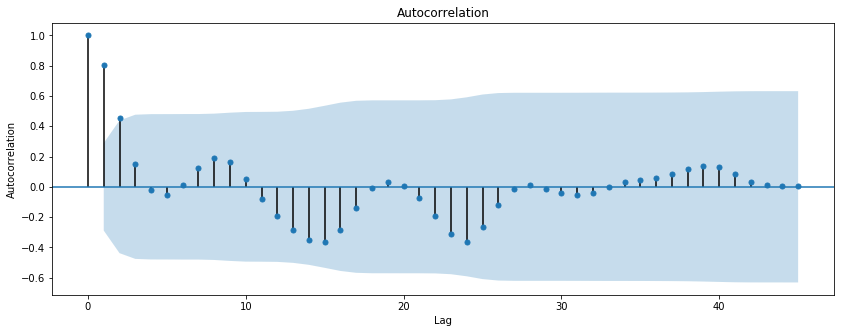

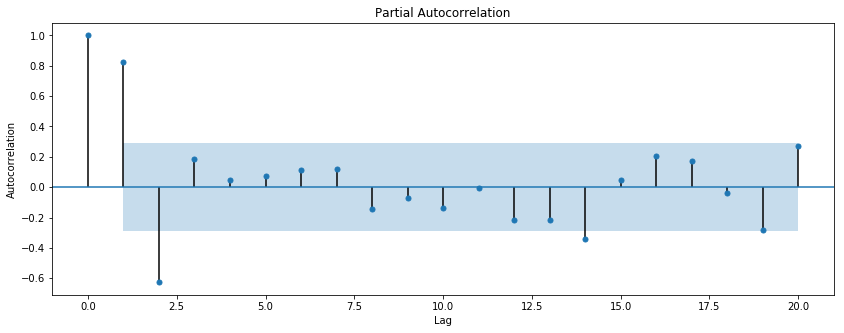

_____________________________________________________________________
60613


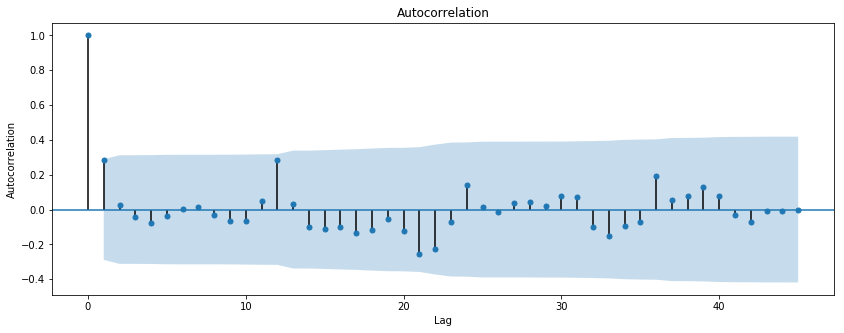

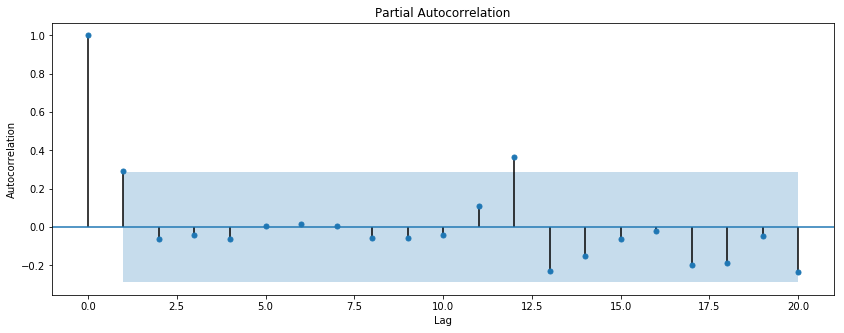

_____________________________________________________________________
60629


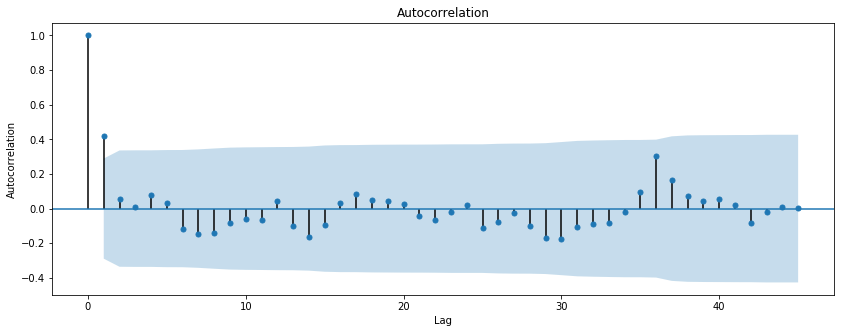

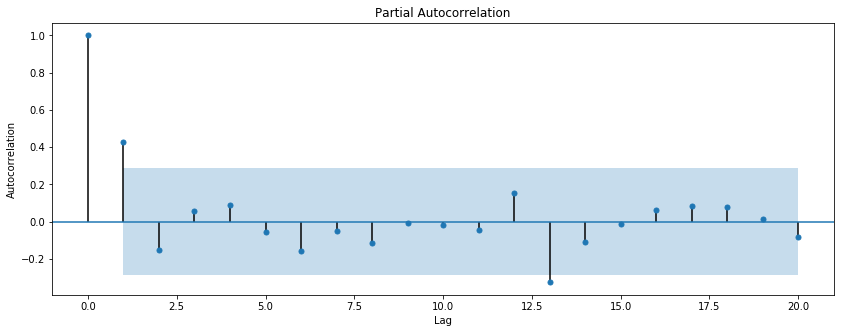

_____________________________________________________________________
60625


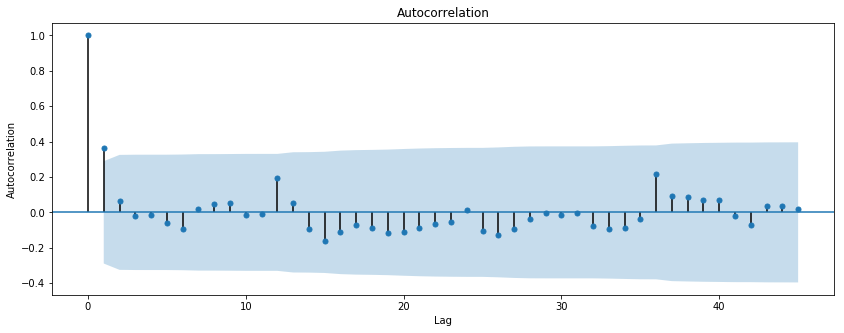

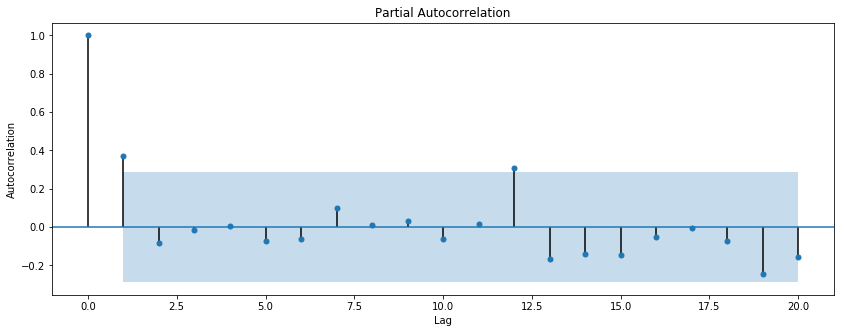

_____________________________________________________________________
60619


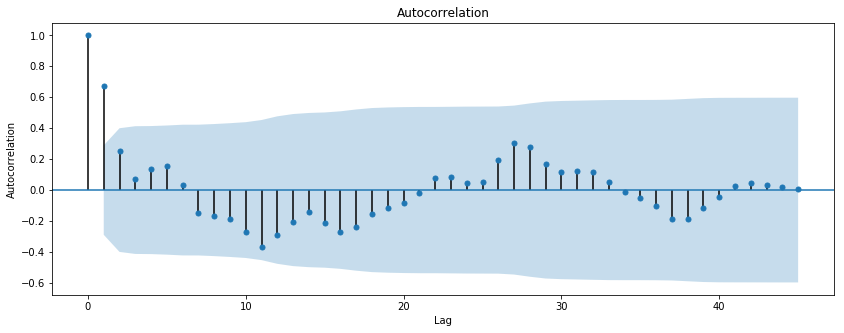

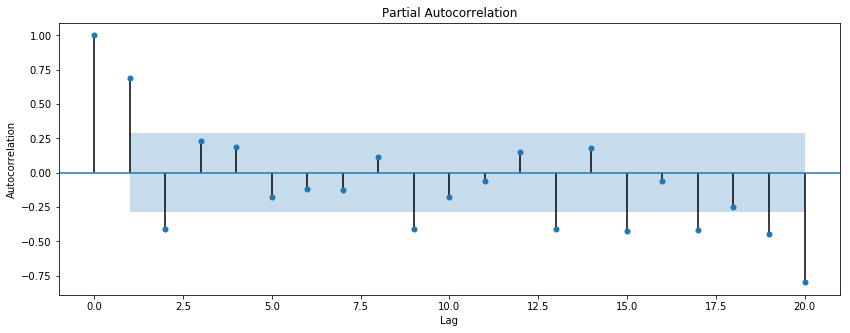

_____________________________________________________________________
60610


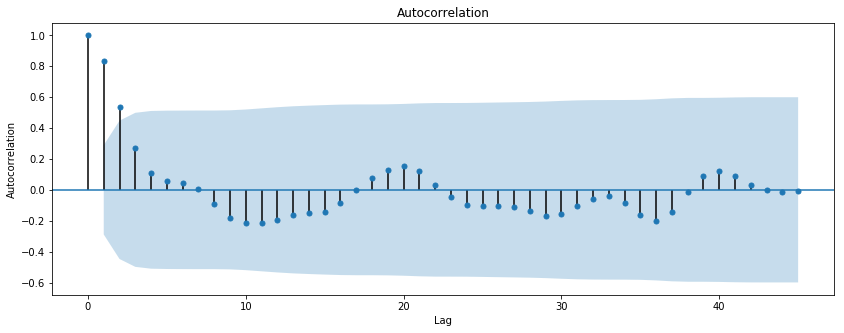

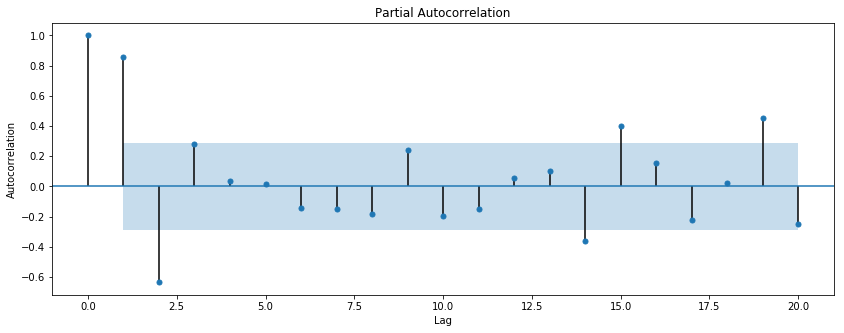

_____________________________________________________________________
60620


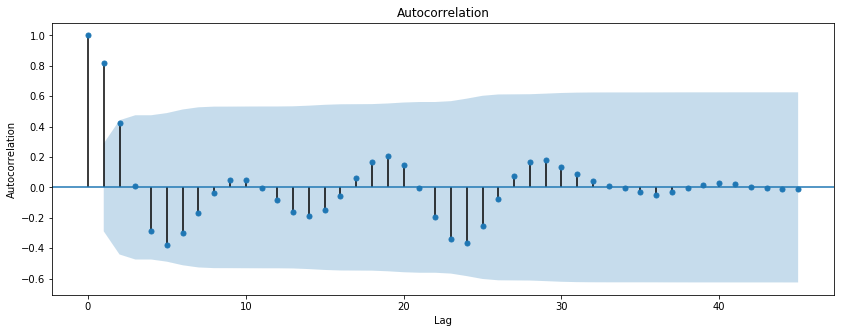

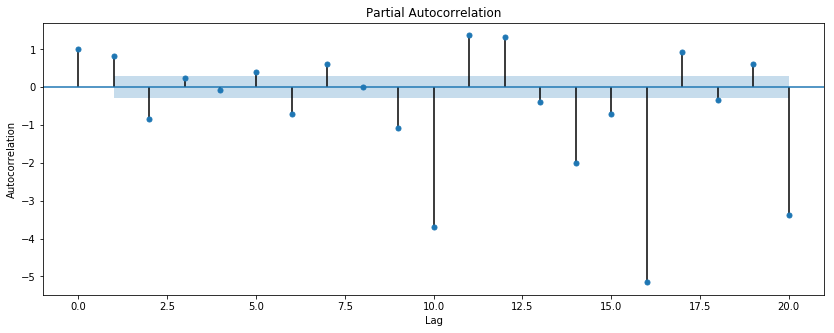

_____________________________________________________________________
60634


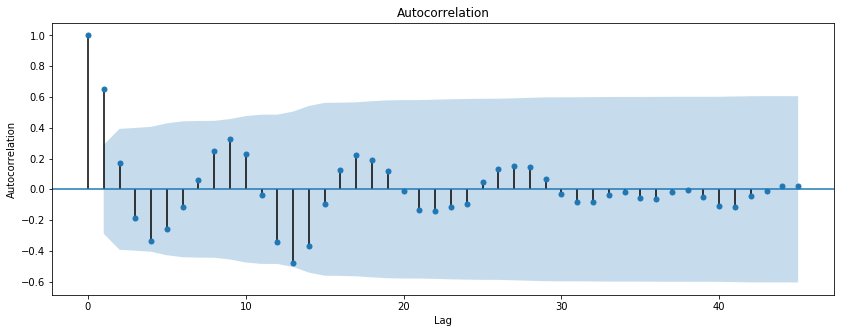

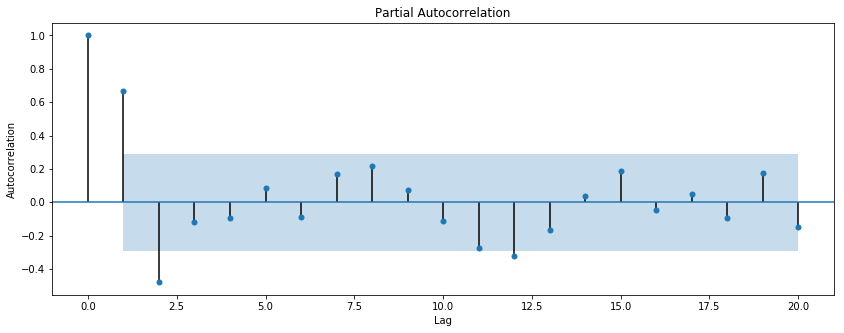

_____________________________________________________________________
60626


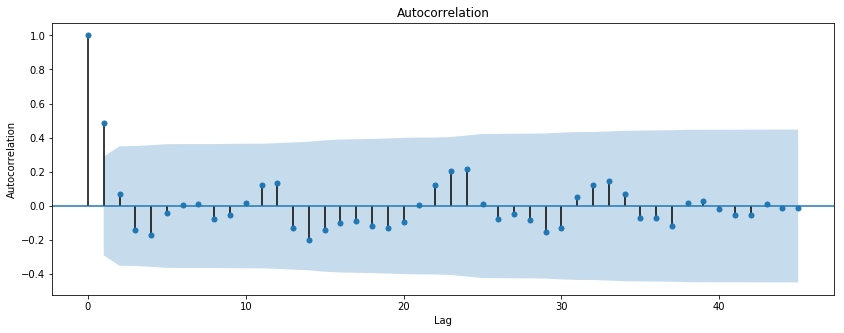

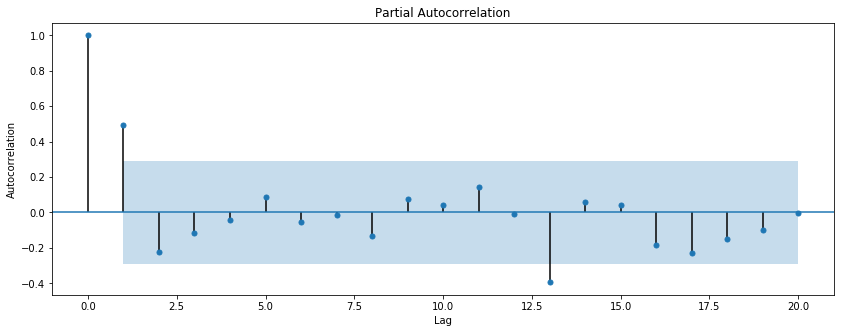

_____________________________________________________________________
60649


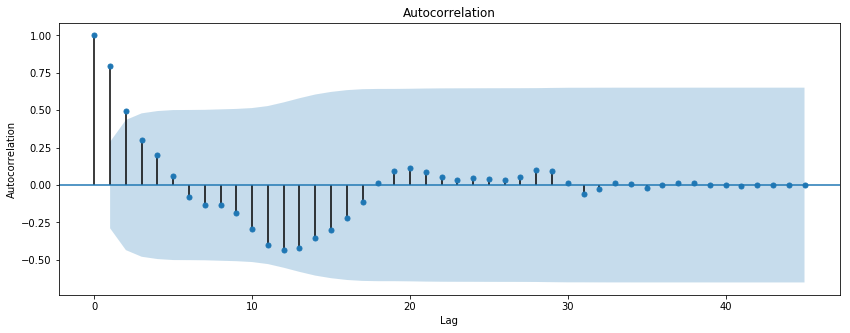

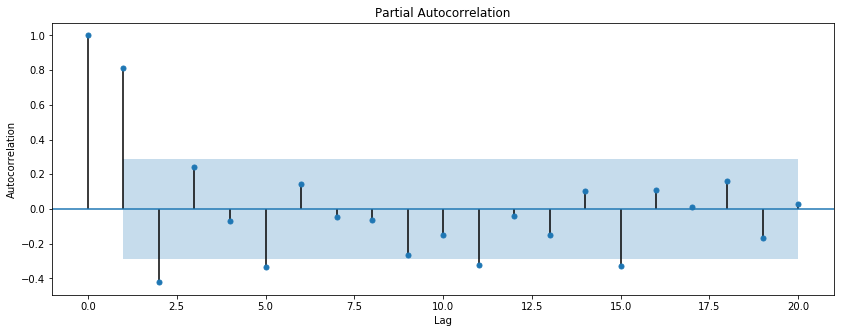

_____________________________________________________________________
60616


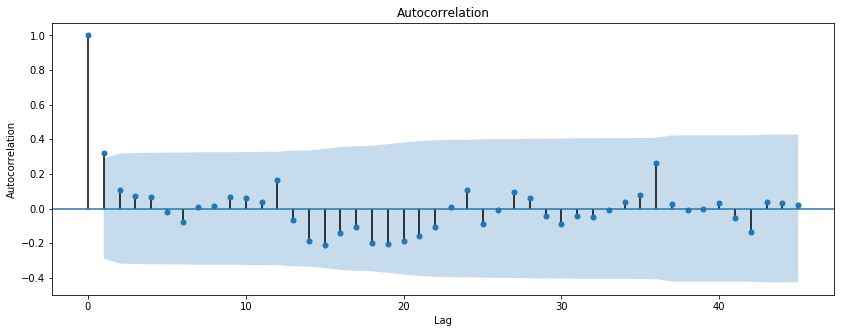

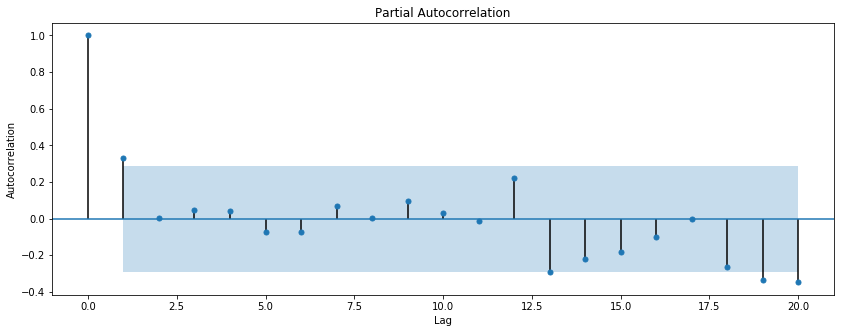

_____________________________________________________________________
60622


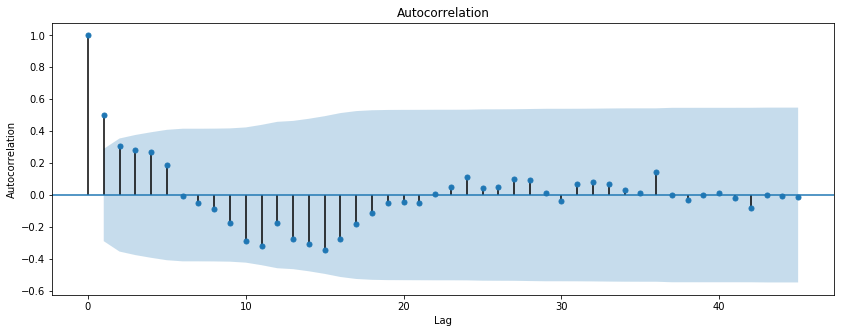

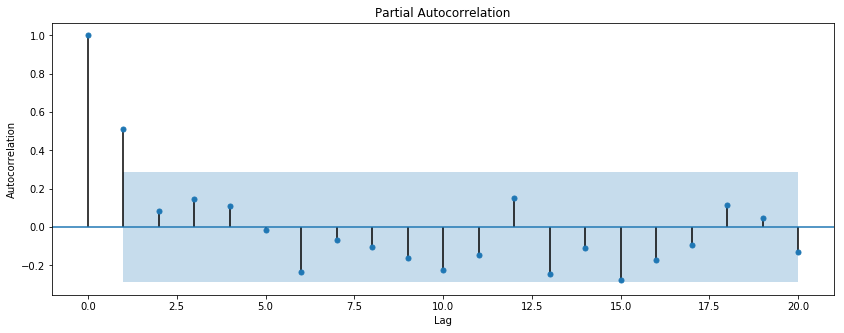

_____________________________________________________________________
60615


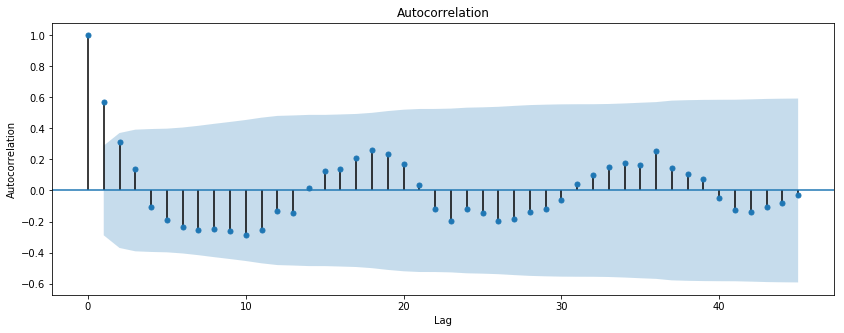

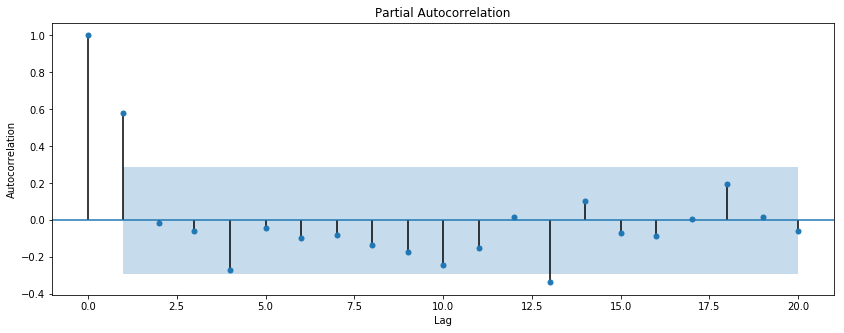

_____________________________________________________________________
60641


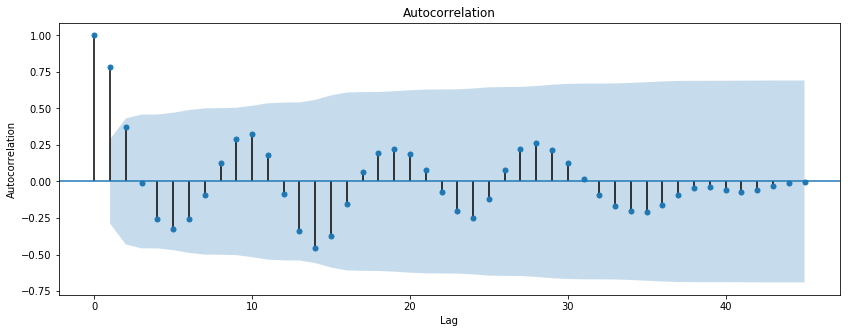

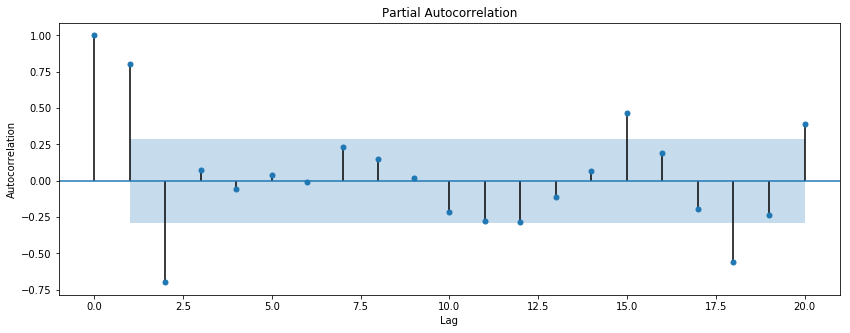

_____________________________________________________________________
60660


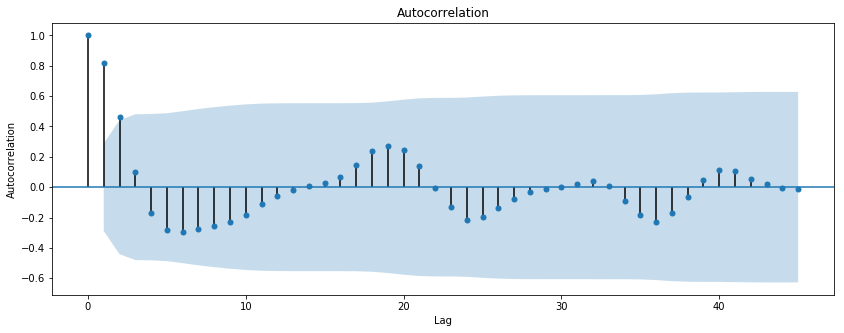

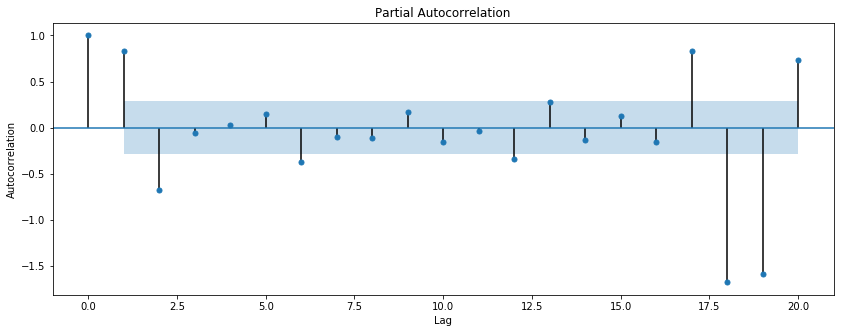

_____________________________________________________________________
60608


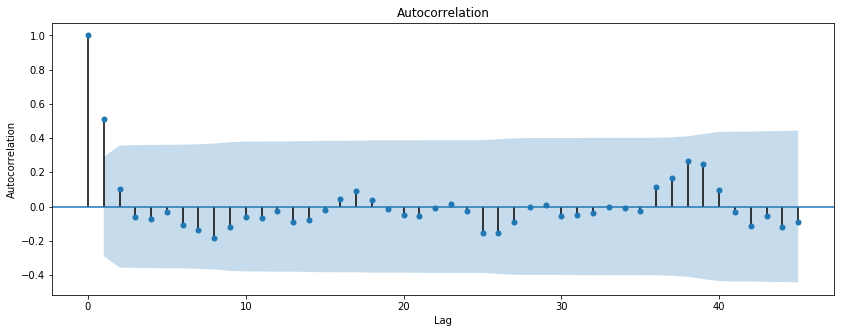

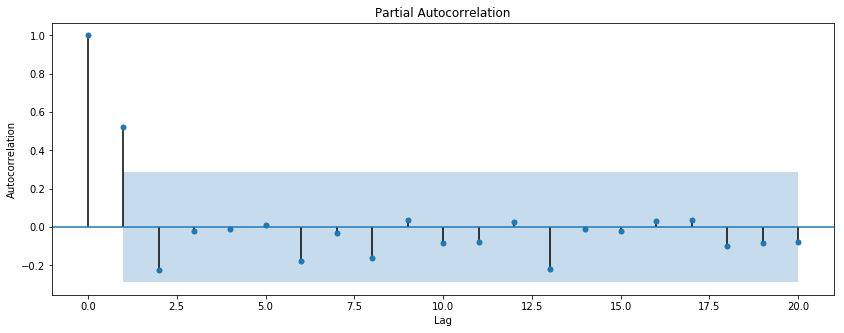

_____________________________________________________________________
60638


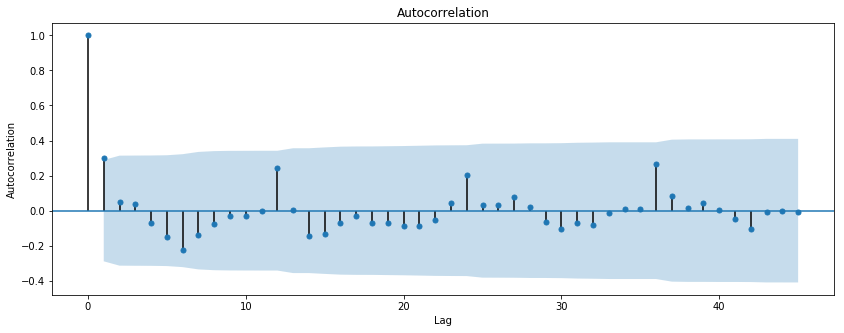

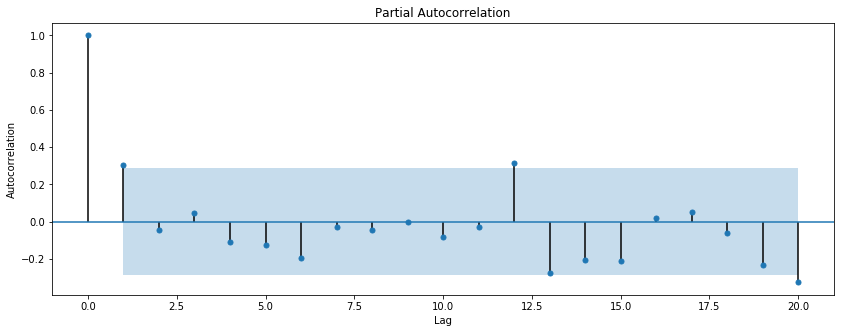

_____________________________________________________________________
60639


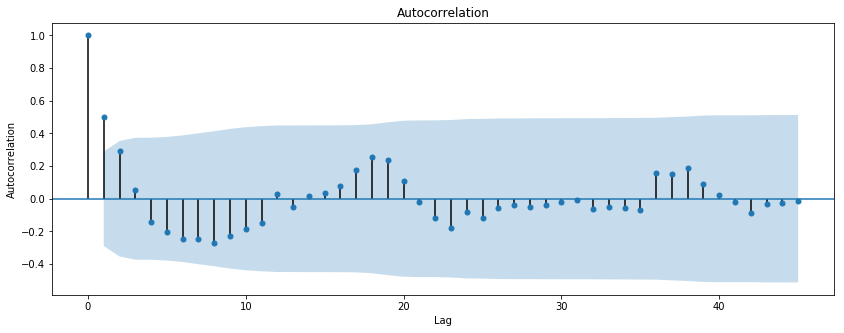

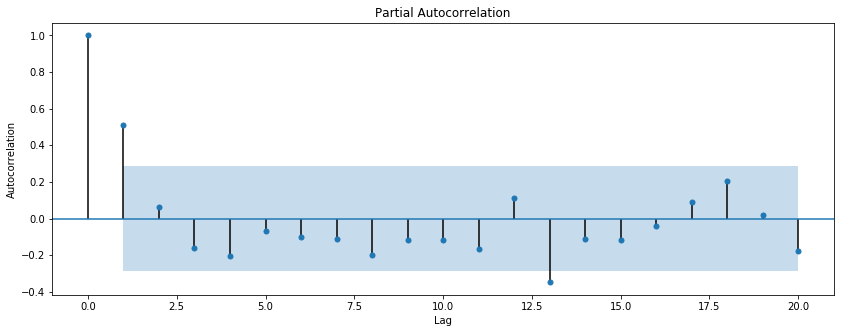

_____________________________________________________________________
60630


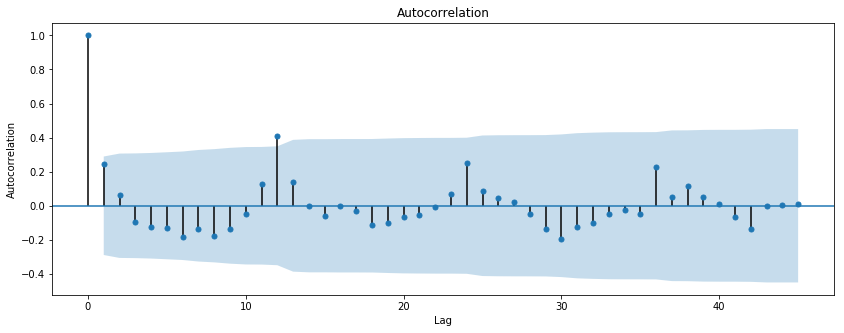

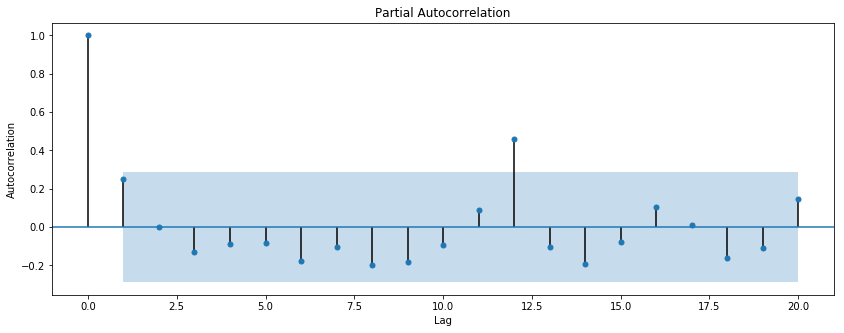

_____________________________________________________________________
60643


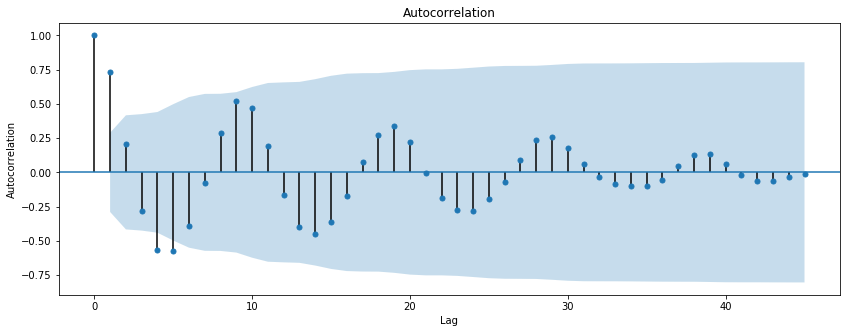

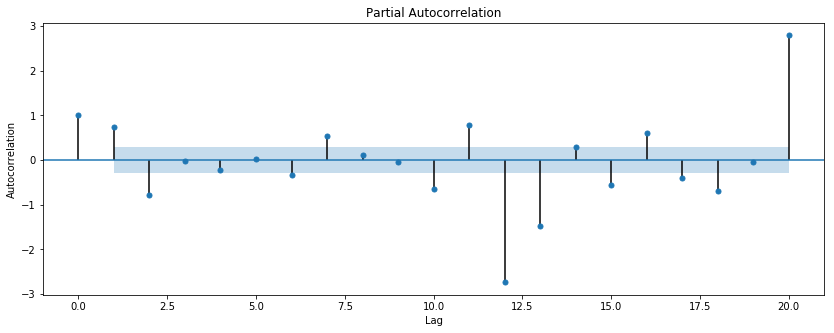

_____________________________________________________________________
60632


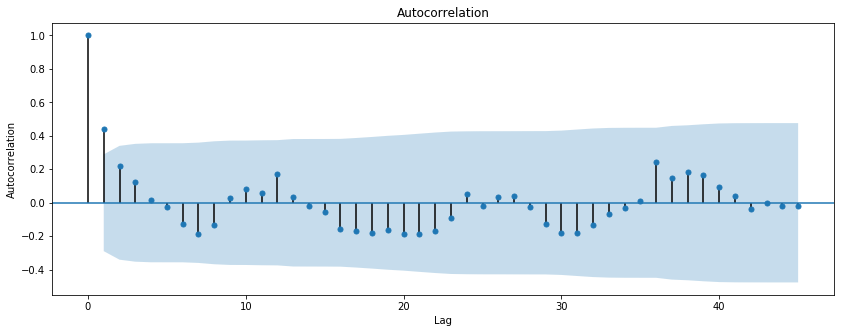

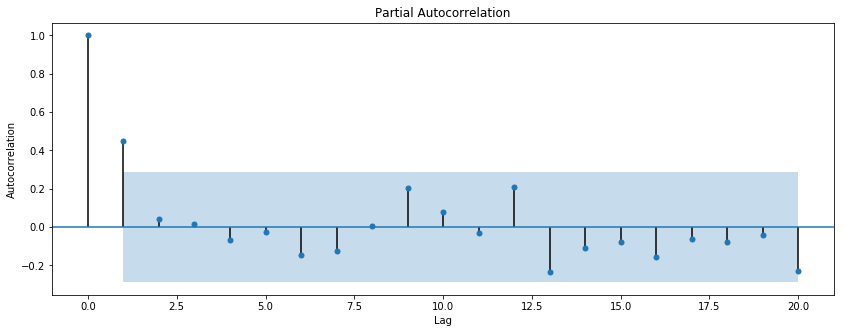

_____________________________________________________________________
60605


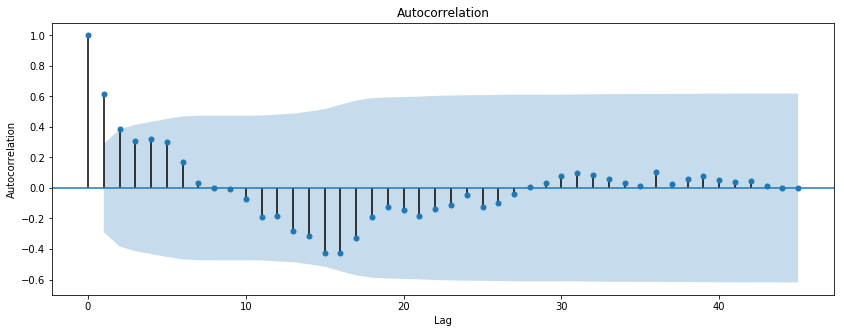

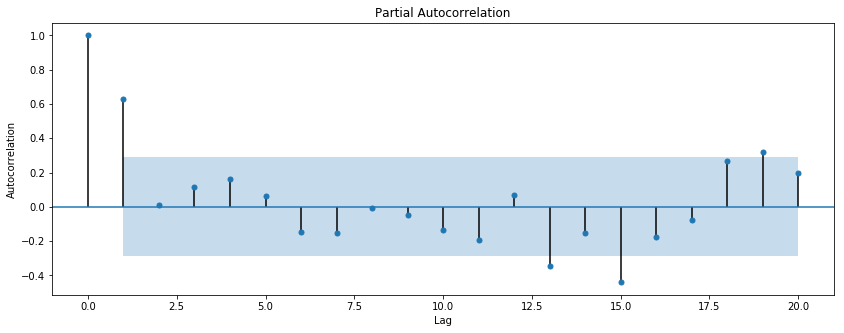

_____________________________________________________________________
60645


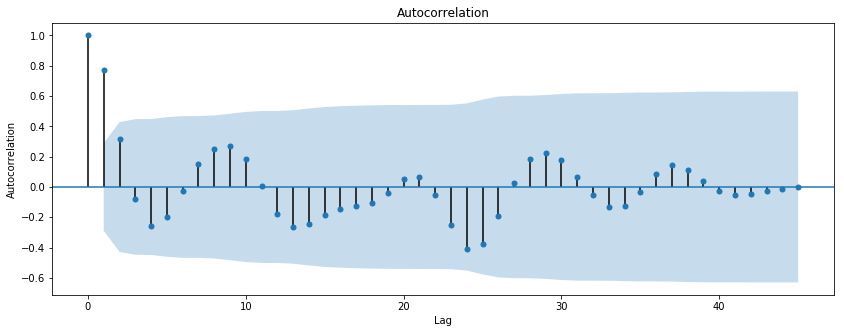

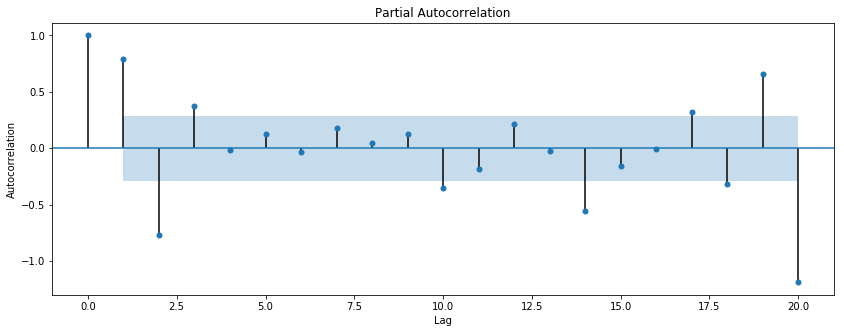

_____________________________________________________________________
60651


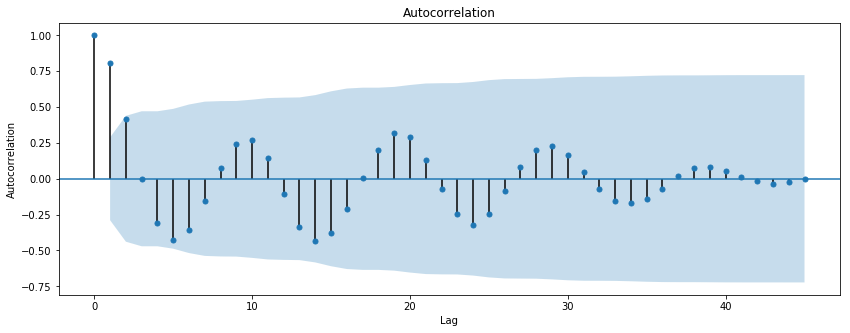

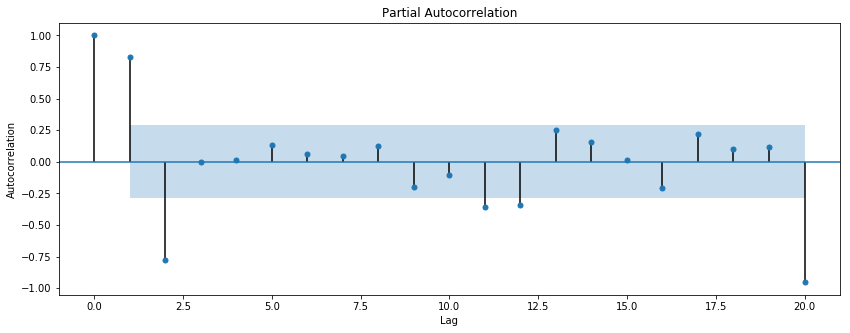

_____________________________________________________________________
60653


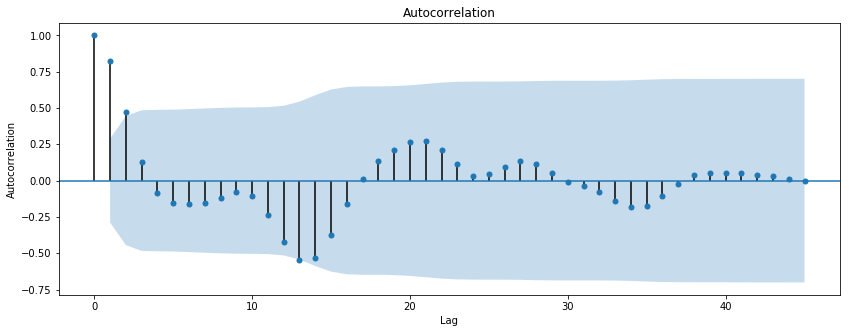

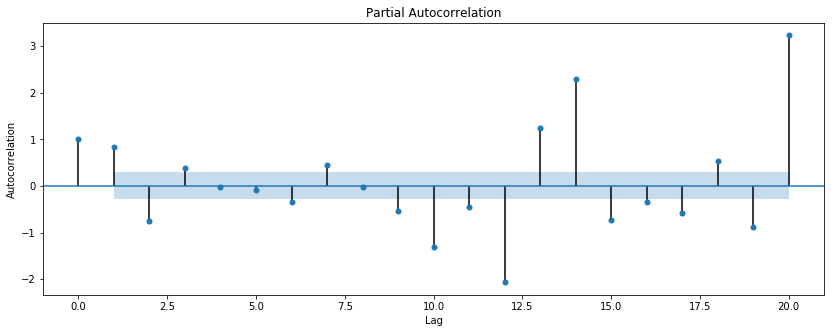

_____________________________________________________________________
60654


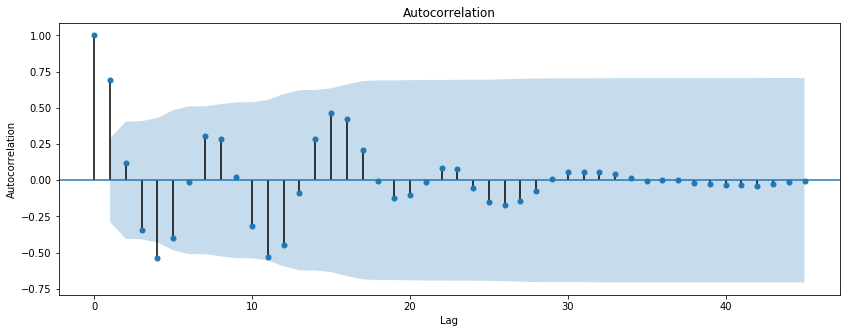

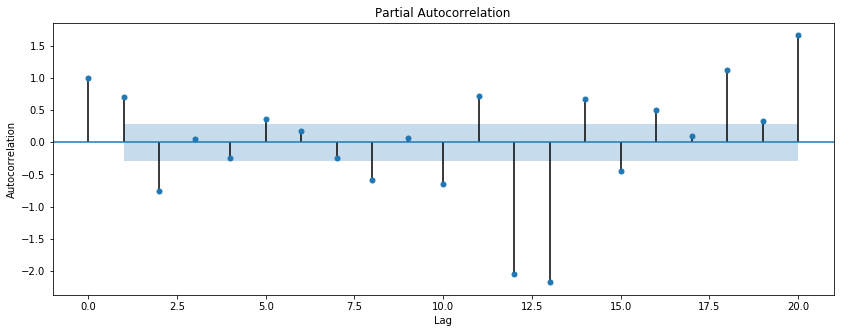

_____________________________________________________________________
60612


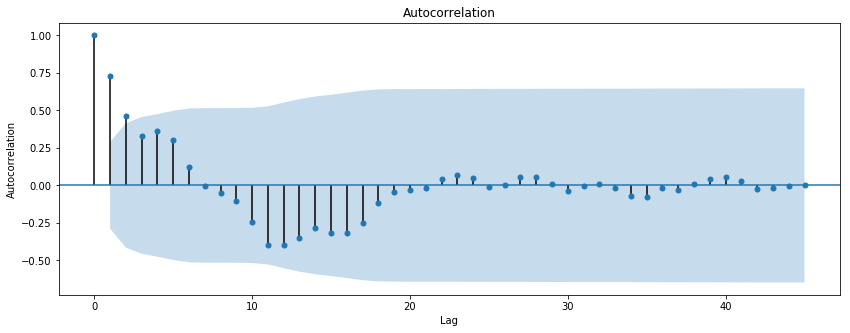

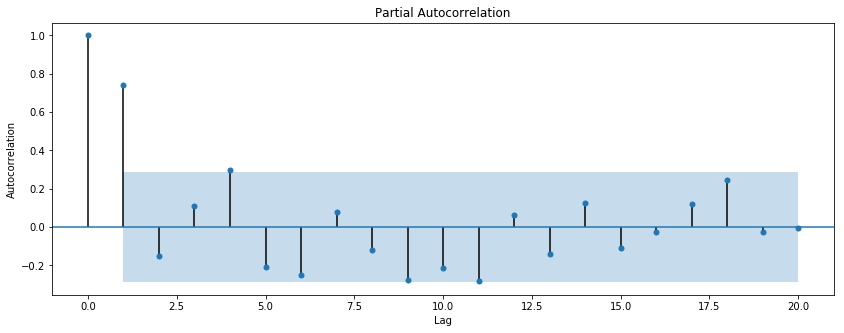

_____________________________________________________________________
60607


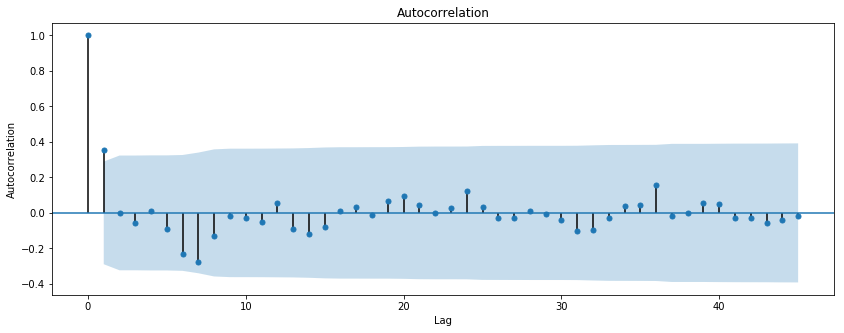

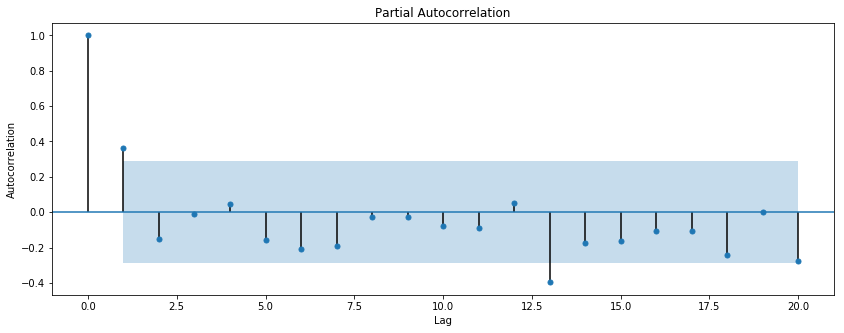

_____________________________________________________________________
60659


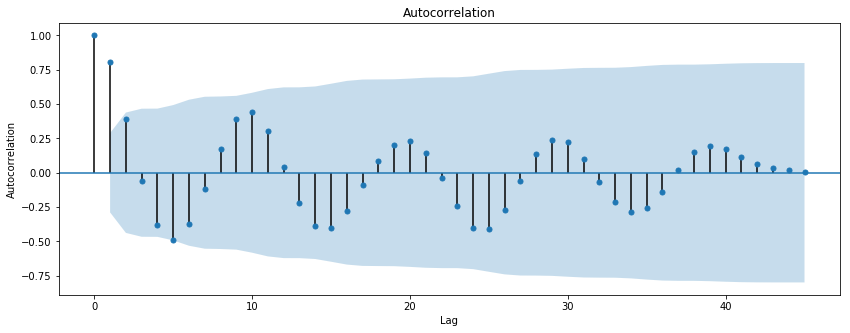

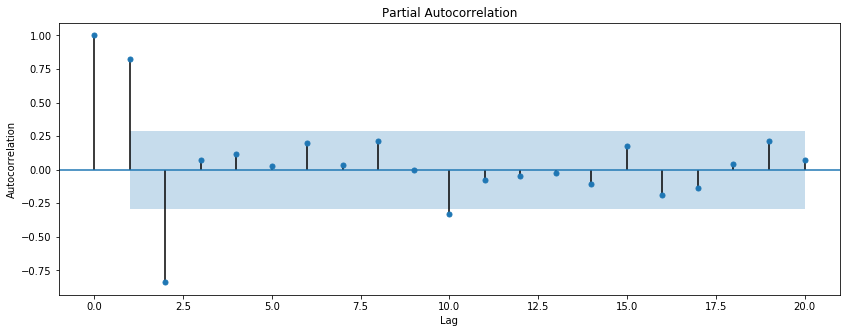

_____________________________________________________________________
60652


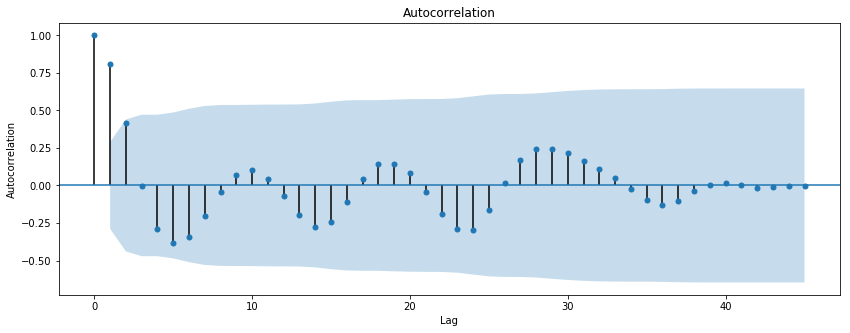

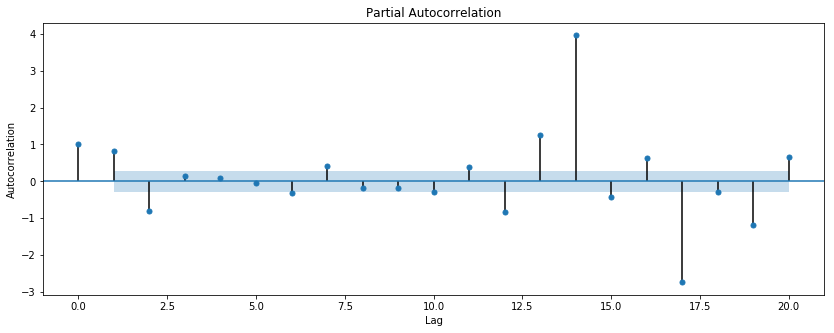

_____________________________________________________________________
60631


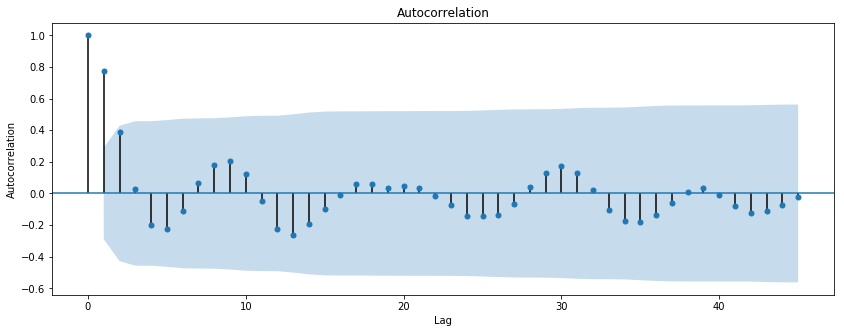

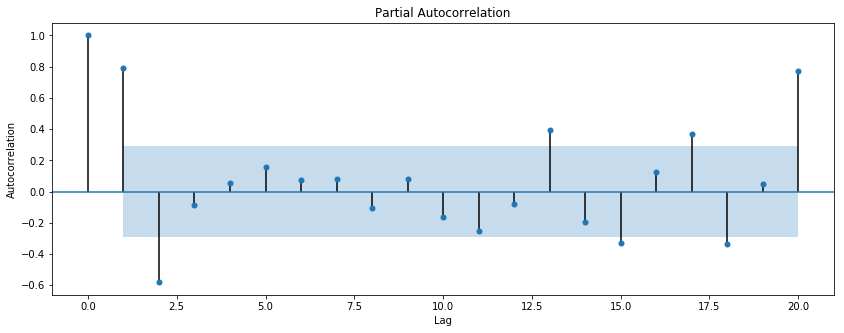

_____________________________________________________________________
60656


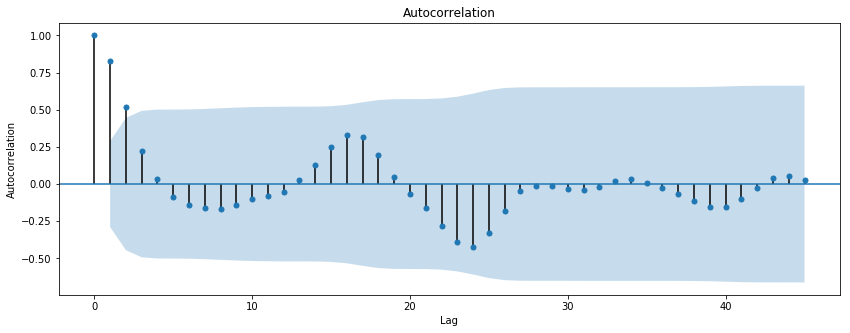

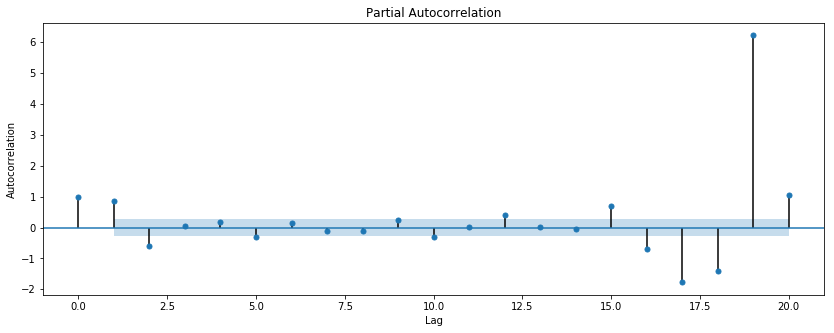

_____________________________________________________________________
60655


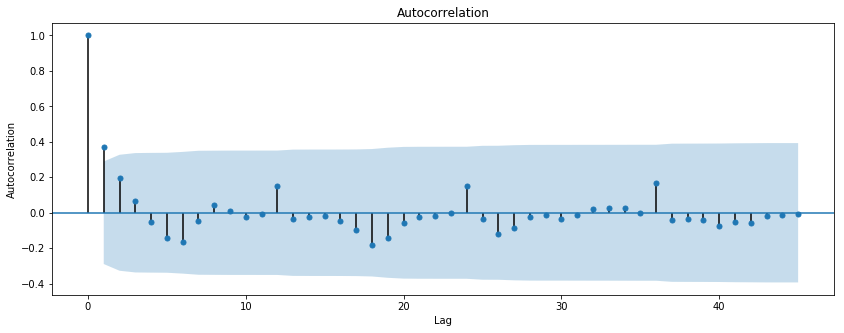

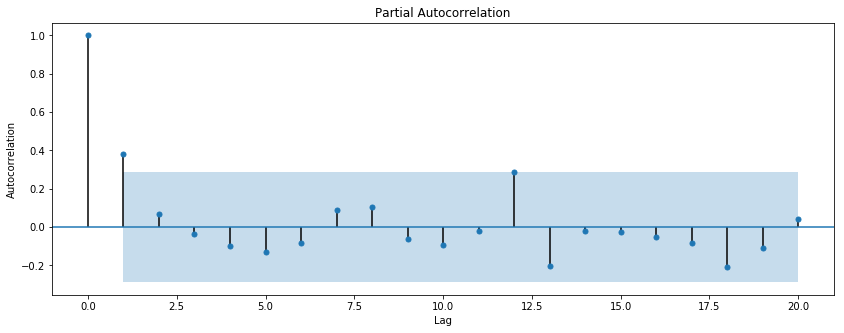

_____________________________________________________________________
60646


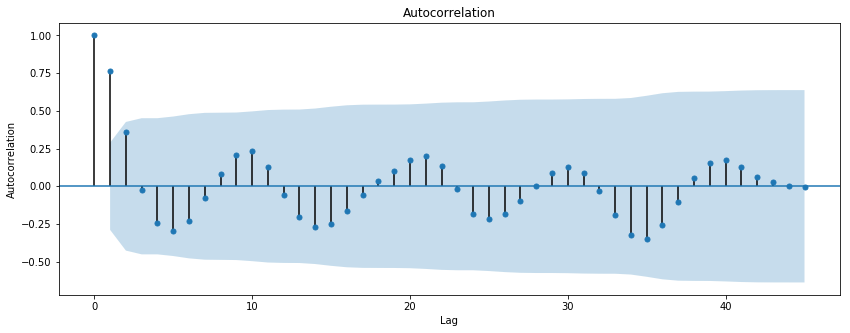

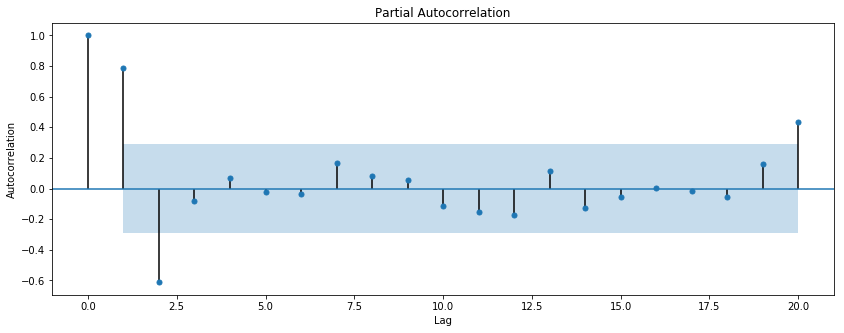

_____________________________________________________________________
60642


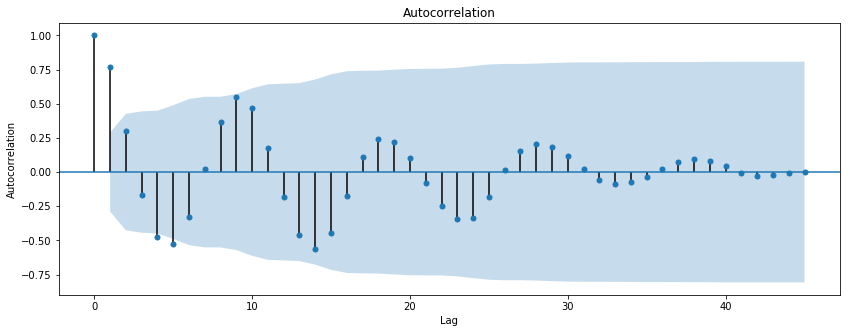

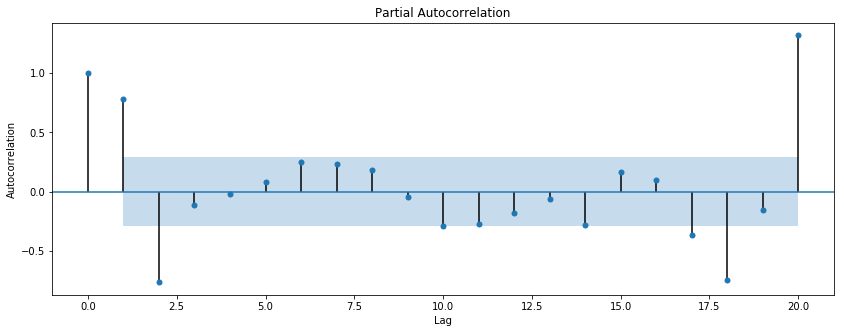

_____________________________________________________________________
60633


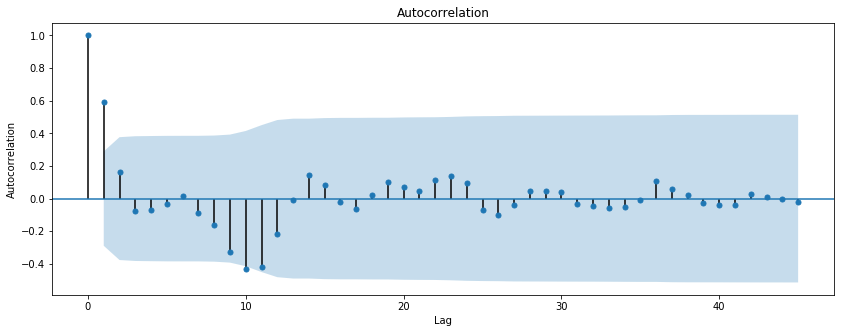

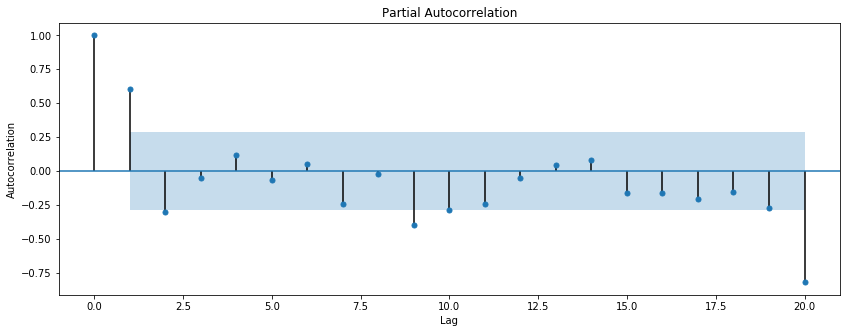

_____________________________________________________________________


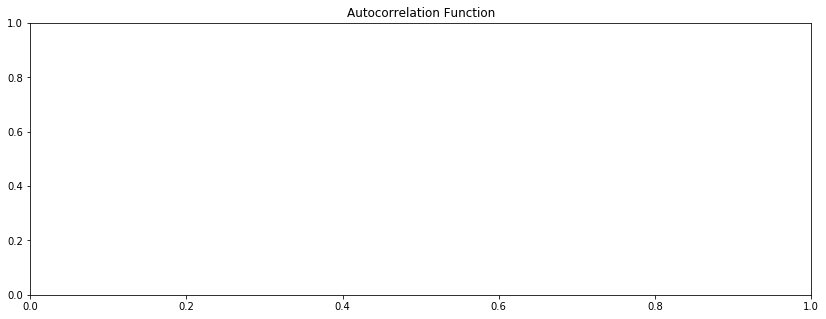

In [40]:
ACF_PACF(zc_train_dt.dropna(), 20)
plt.title('Autocorrelation Function')
plt.show()

### Defining the model

In [ ]:

import itertools

_list = []
for i in [zip(x, q_list) for x in itertools.permutations(p_list, len(q_list))]:
    for j in i:
        _list.append(j)
        
_list = list(set(_list))

for p, q in _list:
    try:
        # AR+I+MA = ARIMA model
        
        model = ARIMA(x, order=(p,1,q))
        results_ARIMA = model.fit(disp=-1)

        plt.figure(figsize=SIZE)
        plt.plot(dx)
        plt.plot(results_ARIMA.fittedvalues, color='orange')
        plt.show()
        
        report_metrics(dx, results_ARIMA.fittedvalues)
        
        print(results_ARIMA.summary())
    except:
        pass